LayoutVAE using cyberagent/crello dataset
===

This notebook is to train LayoutVAE with [Cyberagent Crello dataset](https://huggingface.co/datasets/cyberagent/crello)



# Setup

In [1]:
!pip install skia-python datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency 

In [2]:
# @title Import dependent libraries

from pathlib import Path
import os
import io
import sys
import datasets
from functools import partial
from typing import Any, Dict

import base64
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    optimizers,
    metrics,
)
from scipy.stats import norm

import skia
import matplotlib.pyplot as plt
from IPython.display import Image, HTML, display

# Training Data

In [3]:
# @title Load training data

dataset = datasets.load_dataset("cyberagent/crello")
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']
print(f'train: {dataset_train.shape}')
print(f'val: {dataset_val.shape}')
print(f'test: {dataset_test.shape}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/19095 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1951 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2375 [00:00<?, ? examples/s]

train: (19095, 29)
val: (1951, 29)
test: (2375, 29)


In [4]:
# @title Load label dictionaries
features_train = dataset_train.features

for key, value in features_train.items():
    print(key, value)

id Value(dtype='string', id=None)
length Value(dtype='int64', id=None)
group ClassLabel(names=['SM', 'HC', 'MM', 'SMA', 'EO', 'BG'], id=None)
format ClassLabel(names=['Instagram Story', 'Instagram', 'Facebook', 'Facebook cover', 'Twitter', 'Facebook AD', 'Poster', 'Instagram AD', 'Tumblr', 'Image', 'Pinterest', 'Flayer', 'FB event cover', 'Postcard', 'Invitation', 'Youtube', 'Email header', 'Medium Rectangle', 'Poster US', 'Graphic', 'Large Rectangle', 'Card', 'Logo', 'Title', 'Skyscraper', 'Leaderboard', 'Presentation', 'Gift Certificate', 'VK Universal Post', 'Youtube Thumbnail', 'Business card', 'Book Cover', 'Presentation Wide', 'VK Community Cover', 'Certificate', 'Zoom Background', 'VK Post with Button', 'T-Shirt', 'Instagram Highlight Cover', 'Coupon', 'Letterhead', 'IGTV Cover', 'Schedule Planner', 'Album Cover', 'LinkedIn Cover', 'Storyboard', 'Recipe Card', 'Invoice', 'Resume', 'Menu', 'Mood Board', 'Mind Map', 'Label', 'Newsletter', 'Brochure', 'Ticket', 'Proposal', 'Snapcha

## Visualize Training Data

In [5]:
# @title Retrieve some data to preview
def extract_sequence_example(data, features) -> Dict[str, Any]:
    """Parse and convert tf.train.SequenceExample"""
    output = {}
    for key, val in data.items():
        # print(key, features[key].dtype, val)
        if key in ['group', 'format', 'category', 'canvas_width', 'canvas_height',
                   'suitability', 'industries', 'type', 'font', 'text_align', 'capitalize']:
            if features[key].dtype == 'list':
                if isinstance(features[key], datasets.features.features.ClassLabel):
                    output[key] = [features[key].names[x] for x in val]
                elif isinstance(features[key], datasets.features.features.Sequence):
                    output[key] = [features[key].feature.names[x] for x in val]
                else:
                    output[key] = val
            else:
                output[key] = features[key].names[val]
                if key in ['canvas_width', 'canvas_height']:
                    output[key] = float(output[key])
        else:
            output[key] = val
    return output

dataset_train_examples = []
for data_raw in dataset_train.take(10):
    data_example = extract_sequence_example(data_raw, features_train)
    dataset_train_examples.append(data_example)

In [6]:
# @title Preview with Skia
import dataclasses

@dataclasses.dataclass
class SkiaColor:
    CANVAS: skia.Color = skia.Color(0xEE, 0xEE, 0xEE)
    TEXT: skia.Color = skia.ColorRED
    IMAGE: skia.Color = skia.Color(0x00, 0xFF, 0x00, 0x80)
    SHAPE: skia.Color = skia.Color(0x00, 0x00, 0x00, 0x55)

def render(example: Dict[str, tf.Tensor], is_layout_mode=False, max_size: float=512.) -> bytes:
    """Render parsed sequence example onto an image and return as PNG bytes."""
    canvas_width = example["canvas_width"]
    canvas_height = example["canvas_height"]
    # print(canvas_width, canvas_height)

    scale = min(1.0, max_size / canvas_width, max_size / canvas_height)
    surface = skia.Surface(int(scale * canvas_width), int(scale * canvas_height))

    with surface as canvas:
        canvas.scale(scale, scale)
        # Create a white paint object
        paint = skia.Paint(Color=SkiaColor.CANVAS, AntiAlias=True)
        # Draw a white rectangle on the entire canvas
        canvas.drawRect(skia.Rect(0, 0, canvas_width, canvas_height), paint)
        for index in range(example["length"]):
            left = example["left"][index] * canvas_width
            top = example["top"][index] * canvas_height
            width = example["width"][index] * canvas_width
            height = example["height"][index] * canvas_height
            rect = skia.Rect.MakeXYWH(left, top, width, height)

            angle = example["angle"][index]
            if angle != 0:
                degree = 180. * angle / np.pi
                canvas.save()
                canvas.rotate(degree, left + width / 2., top + height / 2.)

            # print(example['type'][index])
            if is_layout_mode:
                if example['type'][index] == 'textElement':
                    text = example['text'][index]
                    paint = skia.Paint(AntiAlias=True, Color=SkiaColor.TEXT)
                    canvas.drawRect(rect, paint)
                elif example['type'][index] == 'imageElement':
                    paint = skia.Paint(AntiAlias=True, Color=SkiaColor.IMAGE)
                    canvas.drawRect(rect, paint)
                elif example['type'][index] == 'svgElement':
                    paint = skia.Paint(AntiAlias=True, Color=SkiaColor.SHAPE)
                    canvas.drawRect(rect, paint)
            else:
                pil_image = example["image"][index]
                pil_image = pil_image.convert('RGBA') # Ensure the PIL Image is in RGBA format
                image = skia.Image.frombytes( # Convert PIL Image to skia.Image
                    pil_image.tobytes(),
                    pil_image.size,
                    skia.kRGBA_8888_ColorType)
                canvas.drawImageRect(image, rect)

            if angle != 0:
                canvas.restore()

    image = surface.makeImageSnapshot()
    with io.BytesIO() as f:
        image.save(f, skia.kPNG)
        return f.getvalue()



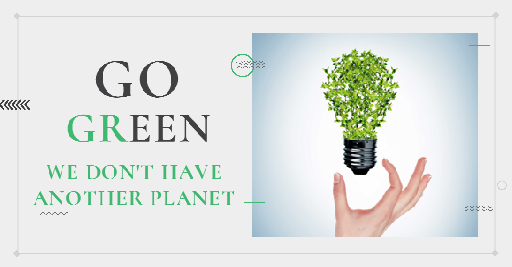
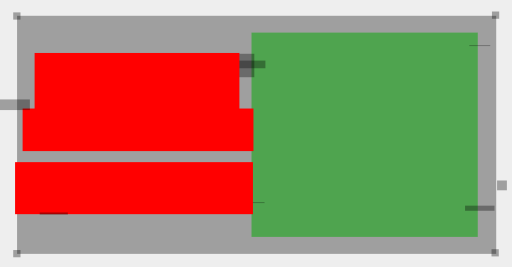


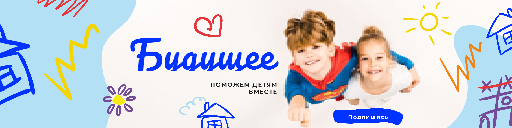
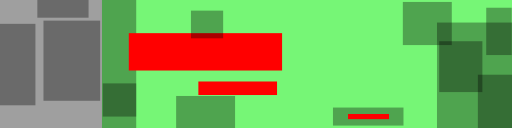


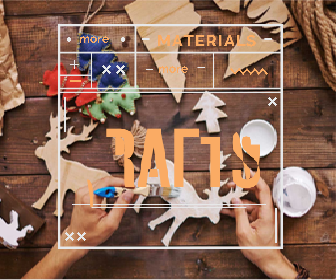
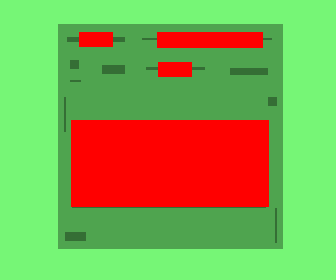


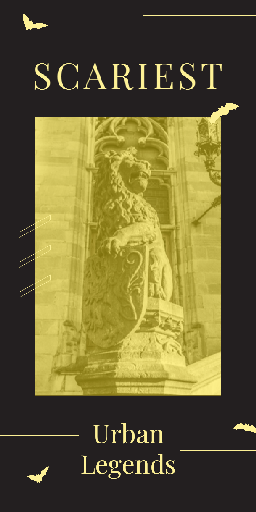
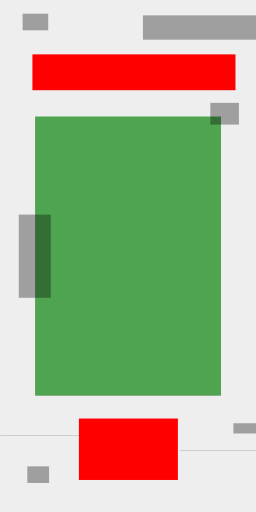


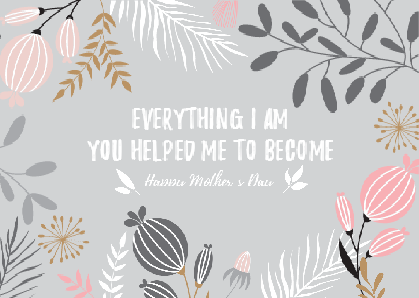
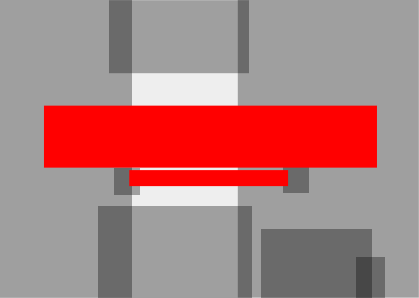


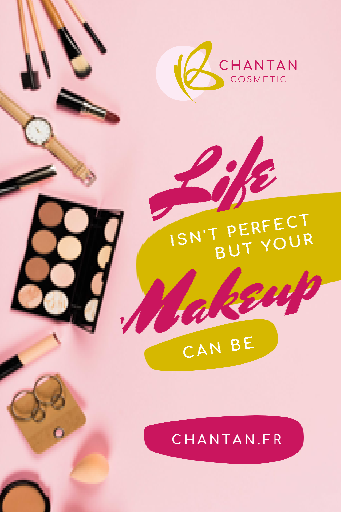
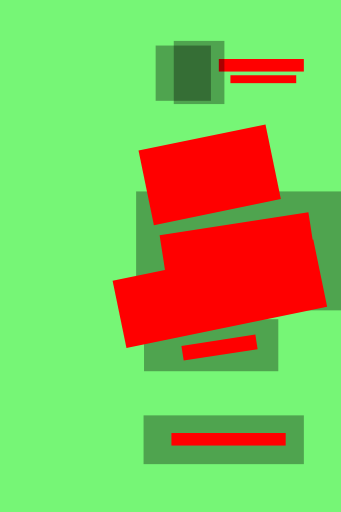


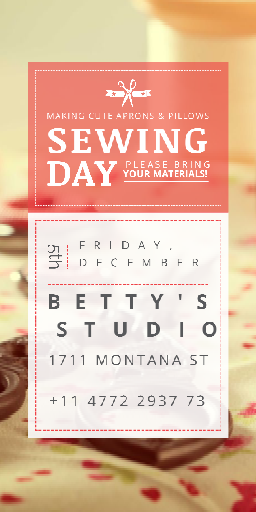
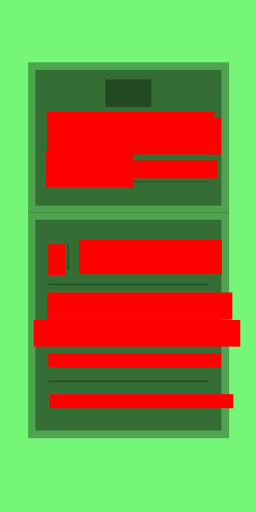


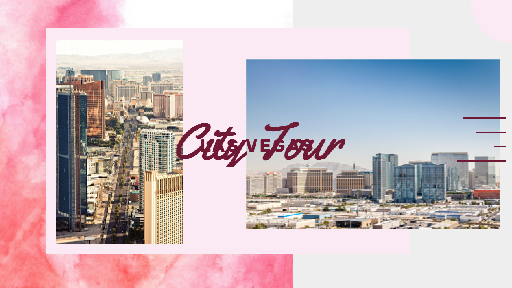
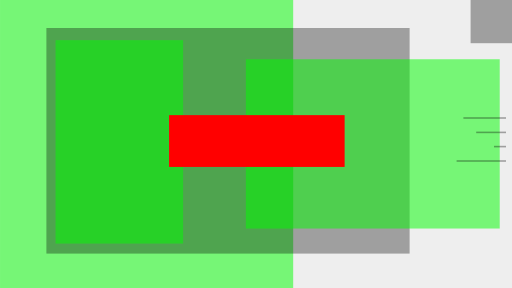


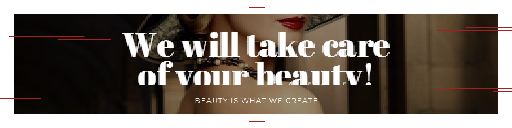
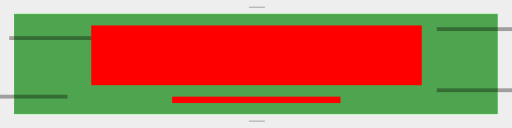


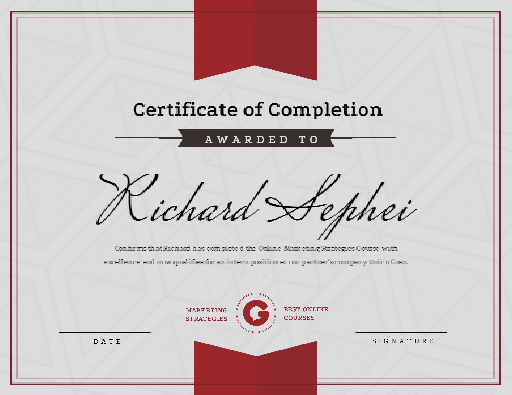
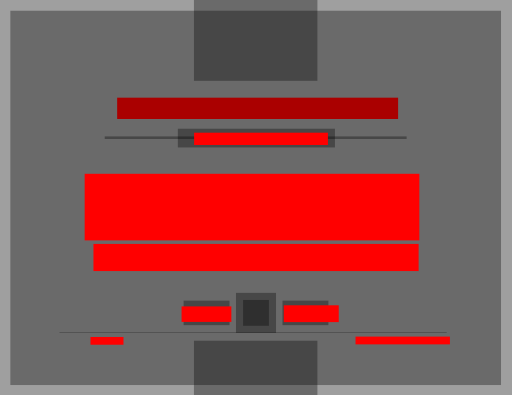

In [7]:
def preview_layout(preview_base64, layout_base64):

    html_content = f"""
<div style="display: flex; flex-direction: row;">
  <div style="flex: 50%;">
    <img src="data:image/png;base64,{preview_base64}" style="width: 65%;">
  </div>
  <div style="flex: 50%;">
    <img src="data:image/png;base64,{layout_base64}" style="width: 65%;">
  </div>
</div>
"""
    display(HTML(html_content))

max_size = 512
for example in dataset_train_examples:
    preview_image_bytes = render(example, max_size=max_size)
    preview_base64_string = base64.b64encode(preview_image_bytes).decode('utf-8')

    layout_image_bytes = render(example, is_layout_mode=True, max_size=max_size)
    layout_base64_string = base64.b64encode(layout_image_bytes).decode('utf-8')

    # display(Image(data=image_bytes, format='png'))
    preview_layout(preview_base64_string, layout_base64_string)


# Constant Params for Training

In [8]:
BATCH_SIZE = 100
# VALIDATION_SPLIT = 0.2
INPUT_DIM = 100
EMBEDDING_DIM = 2
EPOCHS = 300
BETA = 1 # 10
N_PATIENCE = 10
LEARNING_RATE =0.0005

# Preprocess

In [9]:
%%time
# @title Make training / validation data

class Preprocess(layers.Layer):
    def __init__(self, max_length=INPUT_DIM, **kwargs):
        super().__init__(**kwargs)
        self.max_length = max_length

    def get_config(self):
        config = super().get_config().copy()
        return config

    def call(self, inputs):
        # Extract features
        types = inputs['type']
        lefts = inputs['left']
        tops = inputs['top']
        widths = inputs['width']
        heights = inputs['height']

        format = inputs['format']
        category = inputs['category']

        # print(types)
        # print(lefts)
        # print(tops)

        # Pad and cast features to float32
        padded_types = []
        padded_lefts = []
        padded_tops = []
        padded_widths = []
        padded_heights = []
        for type_list, left_list, top_list, width_list, height_list in zip(types, lefts, tops, widths, heights):
            padded_type = tf.pad(type_list, [[0, self.max_length - tf.shape(type_list)[0]]], constant_values=-1)
            padded_left = tf.pad(left_list, [[0, self.max_length - tf.shape(left_list)[0]]], constant_values=-1)
            padded_top = tf.pad(top_list, [[0, self.max_length - tf.shape(top_list)[0]]], constant_values=-1)
            padded_width = tf.pad(width_list, [[0, self.max_length - tf.shape(width_list)[0]]], constant_values=-1)
            padded_height = tf.pad(height_list, [[0, self.max_length - tf.shape(height_list)[0]]], constant_values=-1)

            padded_type = tf.cast(padded_type, tf.float32)
            padded_left = tf.cast(padded_left, tf.float32)
            padded_top = tf.cast(padded_top, tf.float32)
            padded_width = tf.cast(padded_width, tf.float32)
            padded_height = tf.cast(padded_height, tf.float32)

            padded_types.append(padded_type)
            padded_lefts.append(padded_left)
            padded_tops.append(padded_top)
            padded_widths.append(padded_width)
            padded_heights.append(padded_height)

        # Stack the padded lists into tensors
        padded_types = tf.stack(padded_types)
        padded_lefts = tf.stack(padded_lefts)
        padded_tops = tf.stack(padded_tops)
        padded_widths = tf.stack(padded_widths)
        padded_heights = tf.stack(padded_heights)

        # Concatenate features along axis 1
        concatenated_features = tf.concat([padded_types, padded_lefts, padded_tops,
                                           padded_widths, padded_heights], axis=1)
        return concatenated_features, format, category

train_X, train_y_format, train_y_category = Preprocess()(dataset_train)
print(train_X.shape)

val_X, val_y_format, val_y_category = Preprocess()(dataset_val)
print(val_X.shape)

train_X = tf.data.Dataset.from_tensor_slices(train_X).batch(BATCH_SIZE)
train_y_format = tf.data.Dataset.from_tensor_slices(train_y_format).batch(BATCH_SIZE)
train_y_category = tf.data.Dataset.from_tensor_slices(train_y_category).batch(BATCH_SIZE)

val_X = tf.data.Dataset.from_tensor_slices(val_X).batch(BATCH_SIZE)
val_y_format = tf.data.Dataset.from_tensor_slices(val_y_format).batch(BATCH_SIZE)
val_y_category = tf.data.Dataset.from_tensor_slices(val_y_category).batch(BATCH_SIZE)

(19095, 500)
(1951, 500)
CPU times: user 1min 56s, sys: 645 ms, total: 1min 57s
Wall time: 1min 58s


# LayoutVAE

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 500)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  128256    ['encoder_input[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 64)                   8256      ['dense_1[0][0]']             
                                                                                            

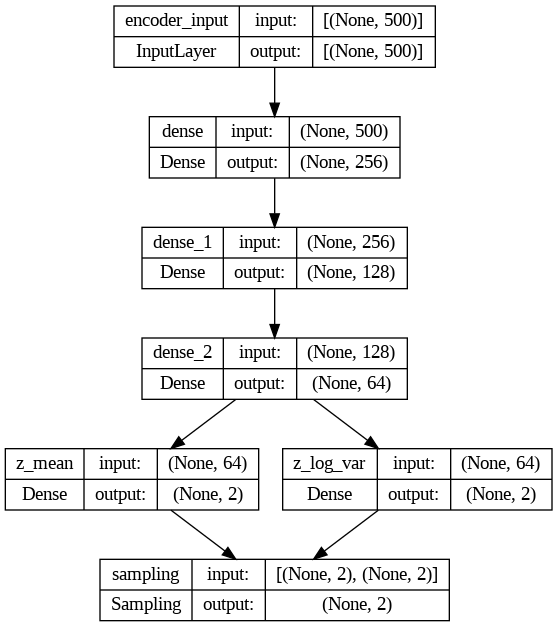

In [10]:
# @title Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) # 平均から離す距離。標準正規分布からサンプリング。
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_input = layers.Input(
    shape=(INPUT_DIM * 5, ), name="encoder_input"
)
x = layers.Dense(256, activation="relu")(encoder_input)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

### VAE extended from AutoEncoder
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
###

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
tf.keras.utils.plot_model(encoder, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 decoder_output (Dense)      (None, 500)               32500     
                                                                 
Total params: 74420 (290.70 KB)
Trainable params: 74420 (290.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


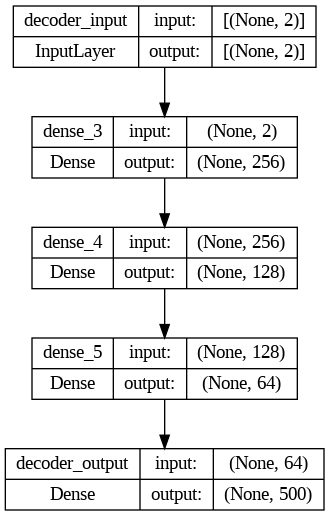

In [11]:
# @title Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(256, activation='relu')(decoder_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
decoder_output = layers.Dense(INPUT_DIM * 5, name='decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()
tf.keras.utils.plot_model(decoder, show_shapes=True)

In [12]:
# @title VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # tracker to store metrics
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'encoder': self.encoder,
            'decoder': self.decoder,
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = config.pop('encoder')
        decoder = config.pop('decoder')
        return cls(encoder, decoder, **config)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                BETA * tf.square(data - reconstruction),
                axis=1,
                )
            )
            # KL loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)

        # reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                BETA * tf.square(data - reconstruction),
                axis=1
            )
        )
        # KL loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [13]:
# @title Compile VAE
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [14]:
# @title Callbacks during training

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
early_stop_callback = callbacks.EarlyStopping(patience=N_PATIENCE, restore_best_weights=True)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [15]:
%%time
# @title Train
vae.fit(
    train_X,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=val_X,
    callbacks=[model_checkpoint_callback,
               early_stop_callback,
               tensorboard_callback],
)

Epoch 1/300
191/191 [==============================] - 7s 24ms/step - total_loss: 88.6536 - reconstruction_loss: 82.0966 - kl_loss: 6.5570 - val_loss: 38.1640 - val_reconstruction_loss: 33.9922 - val_kl_loss: 4.1718
Epoch 2/300
191/191 [==============================] - 5s 24ms/step - total_loss: 27.2818 - reconstruction_loss: 22.7911 - kl_loss: 4.4908 - val_loss: 24.5462 - val_reconstruction_loss: 19.9937 - val_kl_loss: 4.5525
Epoch 3/300
191/191 [==============================] - 4s 20ms/step - total_loss: 21.2568 - reconstruction_loss: 16.7449 - kl_loss: 4.5118 - val_loss: 21.5358 - val_reconstruction_loss: 17.2536 - val_kl_loss: 4.2821
Epoch 4/300
191/191 [==============================] - 4s 22ms/step - total_loss: 19.4259 - reconstruction_loss: 15.4227 - kl_loss: 4.0032 - val_loss: 20.1979 - val_reconstruction_loss: 16.8414 - val_kl_loss: 3.3565
Epoch 5/300
191/191 [==============================] - 5s 27ms/step - total_loss: 17.6918 - reconstruction_loss: 14.6637 - kl_loss: 3.02

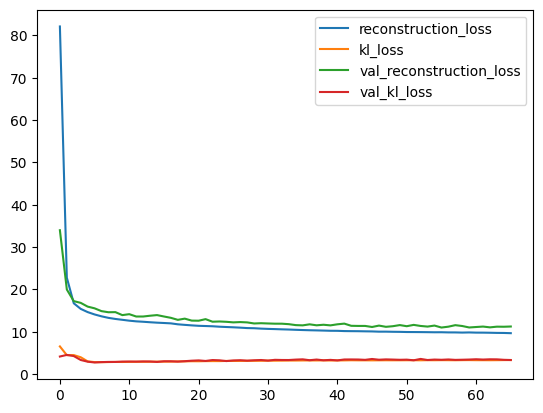

In [16]:
# @title Check Learning Curve

def plot_learning_curve(history):
    keys_to_monitor = ["reconstruction_loss", "kl_loss", "val_reconstruction_loss", "val_kl_loss"]
    plt.plot(pd.DataFrame(history, columns=keys_to_monitor))
    plt.legend(keys_to_monitor)
    plt.show()
plot_learning_curve(vae.history.history)

# Save or Load models

In [22]:
dpath_saved_models = Path('./saved_models')

In [23]:
# @title Save the final models
vae.save(dpath_saved_models / "vae")
encoder.save(dpath_saved_models / "encoder")
decoder.save(dpath_saved_models / "decoder")

In [24]:
# @title Load Saved Models
IS_LOAD_SAVED_MODELS = False
if IS_LOAD_SAVED_MODELS:
    vae = models.load_model(dpath_saved_models / "vae")
    encoder = models.load_model(dpath_saved_models / "encoder")
    decoder = models.load_model(dpath_saved_models / "decoder")

# Setup interactive map


In [25]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.8 MB/s eta 0:00:00


# Review the latent space produced by the encoder

In [26]:
# @title Embed using the encoder
# Encode the example images
z_mean, z_var, z = encoder.predict(train_X)

# Some examples of the embeddings
print(z[:10])

191/191 [==============================] - 2s 9ms/step
[[-0.9427462  -0.59985125]
 [-0.86796695 -0.66986406]
 [-0.98836505 -0.59788847]
 [ 0.4031657  -1.1871789 ]
 [ 0.26130244 -0.36286435]
 [ 0.85193264 -1.2507608 ]
 [-1.6238788  -1.0035655 ]
 [ 0.28969774 -0.371782  ]
 [ 1.2796869  -0.35670987]
 [-1.3626949  -0.9038257 ]]


(19095,)


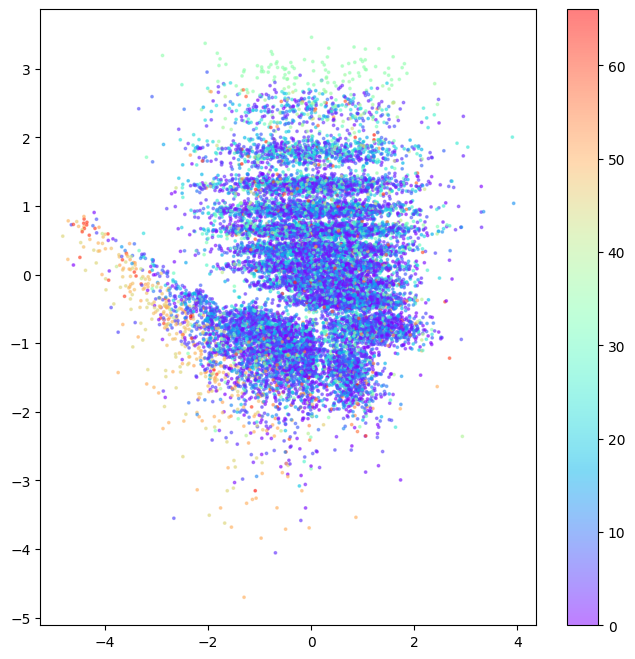

In [27]:
# @title Render the codes with format labels in 2D space

example_labels = []
for data in train_y_format:
    example_labels.append(data)
example_labels = tf.concat(example_labels, axis=0)
print(example_labels.shape)

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt1 = plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=3)
plt.colorbar(plt1)
plt.show()

(19095,)


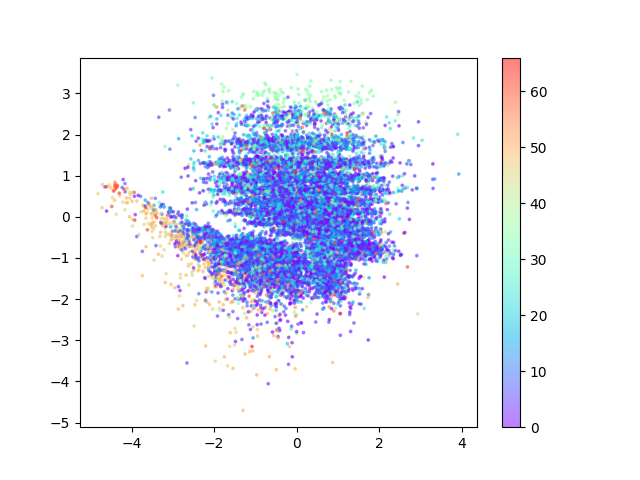

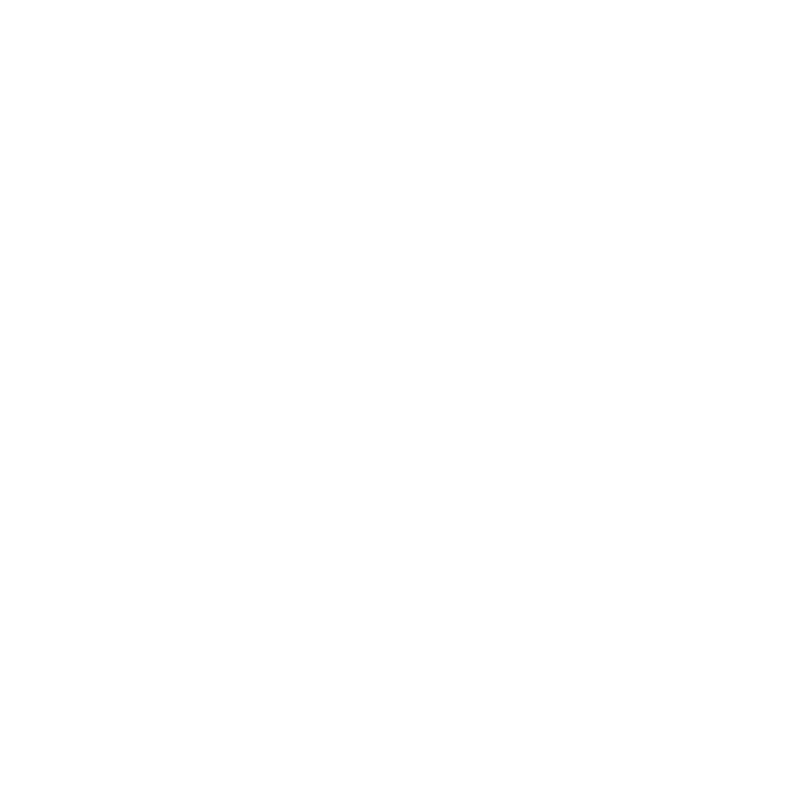

In [28]:
# @title Review format labels on interactive scatter map
%matplotlib ipympl

# get list of labels
example_labels = []
for data in train_y_format:
    example_labels.append(data)
example_labels = tf.concat(example_labels, axis=0)
print(example_labels.shape)



figsize = 8
plt.figure(figsize=(figsize, figsize))
fig, ax = plt.subplots()

# scatter with color labels
sc = plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=3)
plt.colorbar(sc).ax.set_zorder(-1) # Set z-order of colorbar to be behind other elements

# enable scatter dots clickable
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos

    unique_format_classes = set([example_labels[i].numpy() for i in ind["ind"]])
    text = ', '.join([features_train['format'].names[i] for i in set(unique_format_classes)])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor("white")
    annot.get_bbox_patch().set_alpha(0.8)

def event_listener_hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", event_listener_hover)
plt.show()

# Layout reconstruction from latent space

In [31]:
# @title rendering functions to show the reconstructed layouts
def draw_reconstruction(reconstruction, max_size: float=512.) -> bytes:
    '''Draw the given layout on Skia canvas and returns as PNG.'''

    reconstruction = tf.reshape(reconstruction, (-1, INPUT_DIM))
    # print(reconstruction.shape)

    types = reconstruction[0, :]
    lefts = reconstruction[1, :]
    tops = reconstruction[2, :]
    widths = reconstruction[3, :]
    heights = reconstruction[4, :]

    # print(types)
    # print(lefts)
    # print(tops)
    # print(widths)
    # print(heights)

    canvas_width = 512
    canvas_height = 512

    scale = min(1.0, max_size / canvas_width, max_size / canvas_height)
    surface = skia.Surface(int(scale * canvas_width), int(scale * canvas_height))

    with surface as canvas:
        canvas.scale(scale, scale)
        # Create a white paint object
        paint = skia.Paint(Color=SkiaColor.CANVAS, AntiAlias=True)
        # Draw a white rectangle on the entire canvas
        canvas.drawRect(skia.Rect(0, 0, canvas_width, canvas_height), paint)
        for i, type in enumerate(types):
            type_class = round(type.numpy())
            if type_class < 0 or type_class > len(features_train['type'].feature.names) - 1:
                continue
            type_str = features_train['type'].feature.names[type_class]
            left = lefts[i] * canvas_width
            top = tops[i] * canvas_height
            width = widths[i] * canvas_width
            height = heights[i] * canvas_height
            rect = skia.Rect.MakeXYWH(left, top, width, height)

            if type_str == 'textElement':
                paint = skia.Paint(AntiAlias=True, Color=SkiaColor.TEXT)
                canvas.drawRect(rect, paint)
            elif type_str == 'imageElement':
                paint = skia.Paint(AntiAlias=True, Color=SkiaColor.IMAGE)
                canvas.drawRect(rect, paint)
            elif type_str == 'svgElement':
                paint = skia.Paint(AntiAlias=True, Color=SkiaColor.SHAPE)
                canvas.drawRect(rect, paint)

    image = surface.makeImageSnapshot()
    with io.BytesIO() as f:
        image.save(f, skia.kPNG)
        return f.getvalue()

def preview_layout(previews_base64):
    '''Render the given base64 images on HTML.'''

    width_ratio = 1.0 / len(previews_base64) * 100
    content_html = ''
    for i, preview_base64 in enumerate(previews_base64):
        content_html += f"""<div style="flex: {width_ratio}%;">
            <img src="data:image/png;base64,{preview_base64}" style="width: 65%;">
        </div>"""

    html_content = f"""<div style="display: flex; flex-direction: row;">
        {content_html}
    </div>"""
    display(HTML(html_content))


In [32]:
# @title Sampling from latent space

# create coordinate vectors to make grid data
grid_size = 10  # Number of points in each direction
x = tf.linspace(-2.0, 2.0, grid_size)
y = tf.linspace(-2.0, 2.0, grid_size)

# create the mesh grid
X, Y = tf.meshgrid(x, y)

# concatenate the coordinates into a single tensor
z_sample = tf.concat([tf.reshape(X, [-1, 1]), tf.reshape(Y, [-1, 1])], axis=1)

# decode the sampled points
reconstructions = decoder.predict(z_sample)
reconstructions.shape

4/4 [==============================] - 0s 6ms/step


(100, 500)

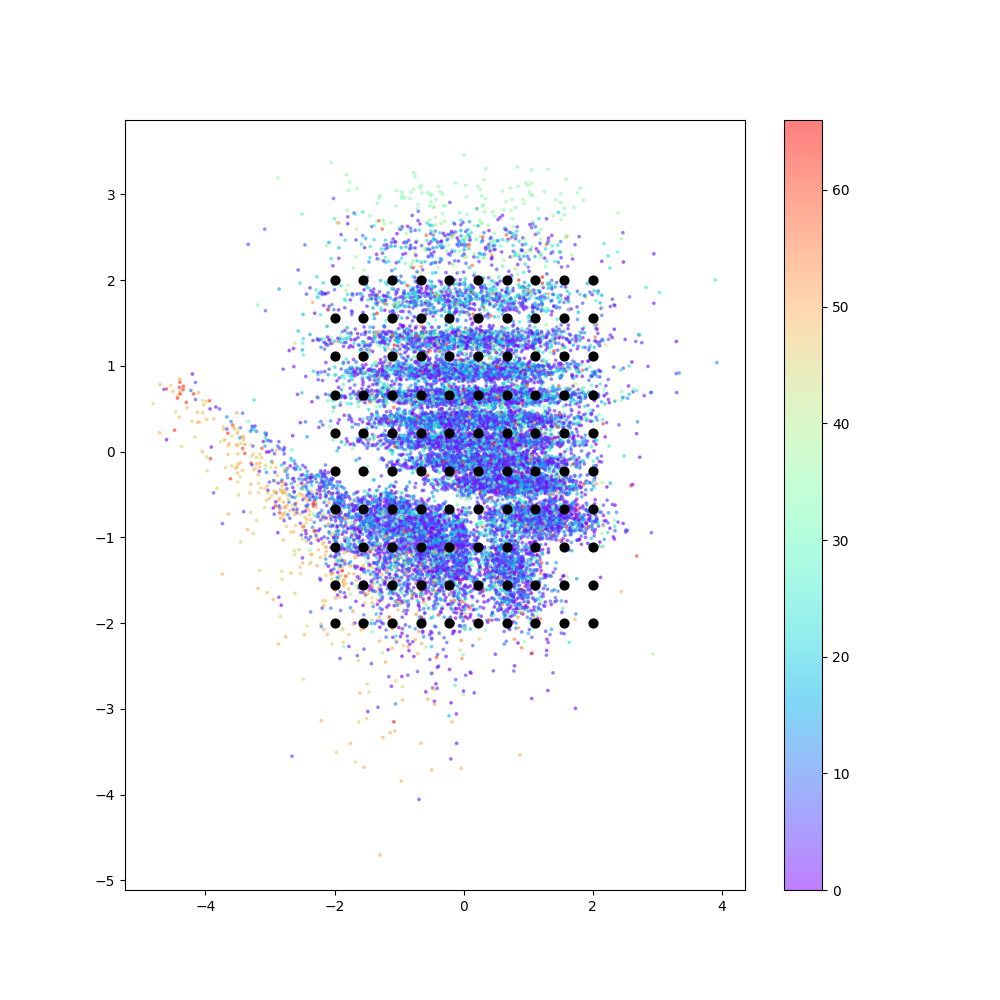


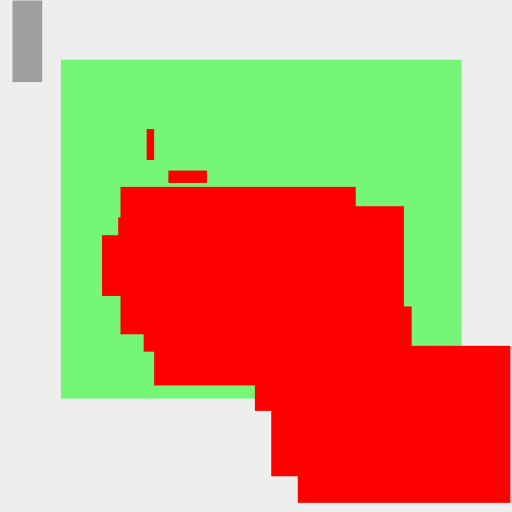
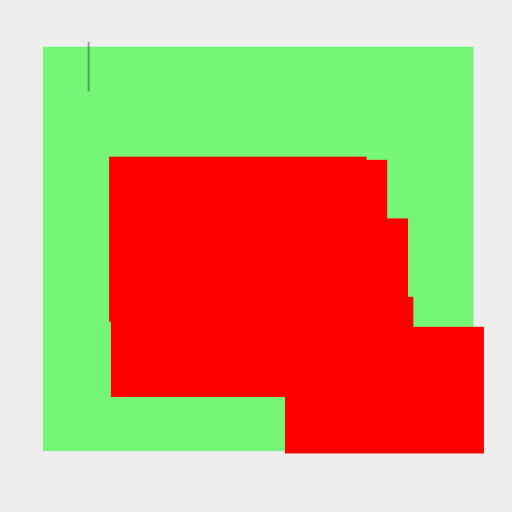
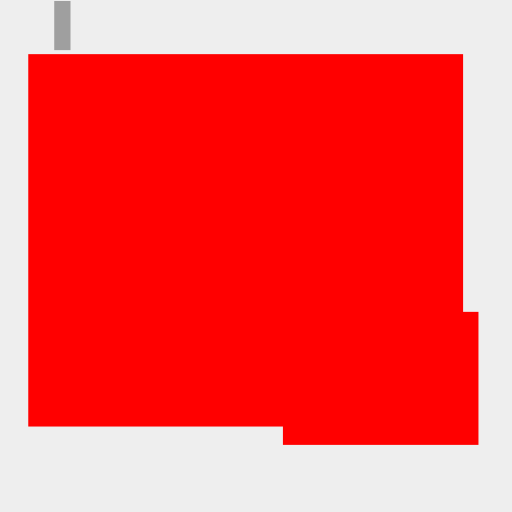
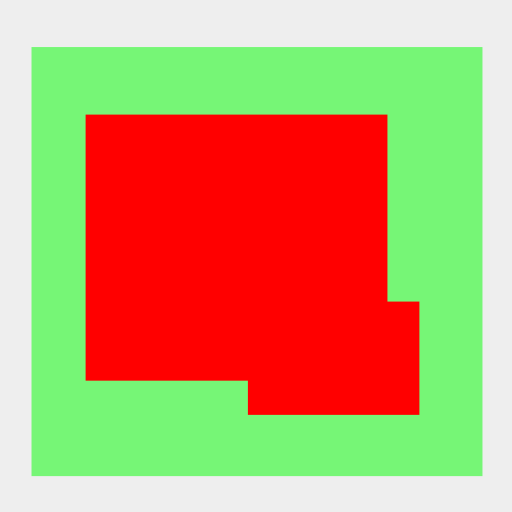
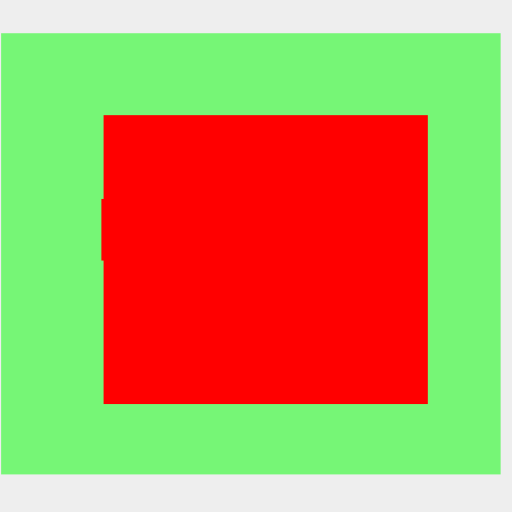
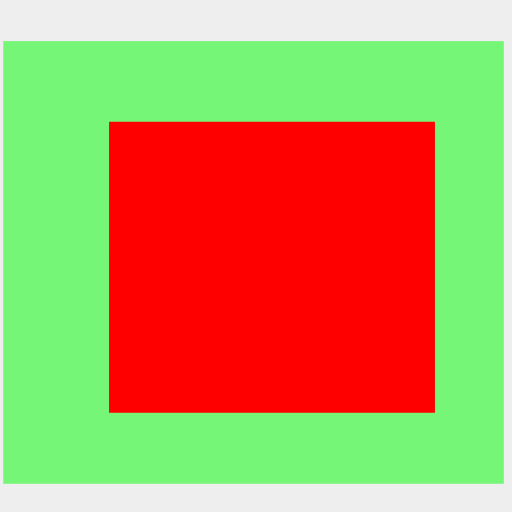
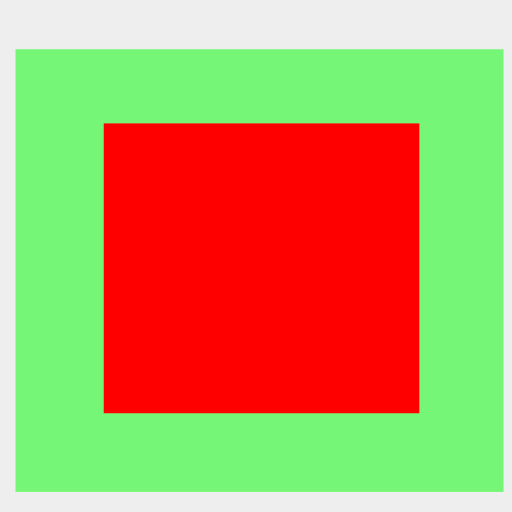
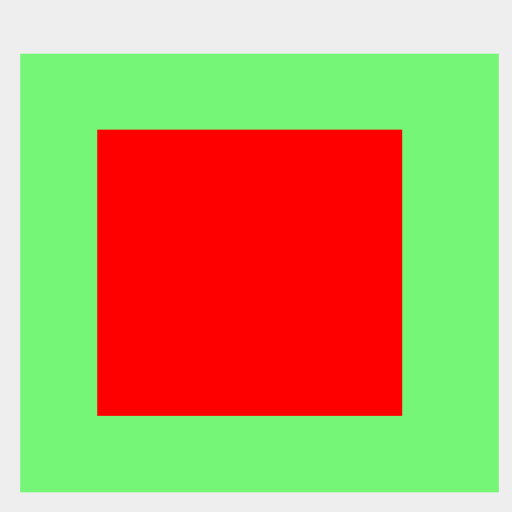
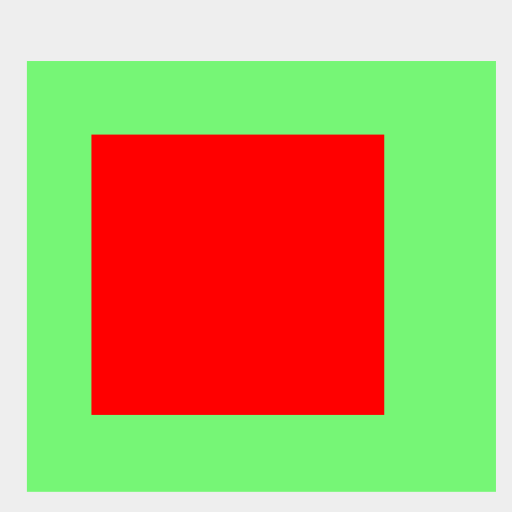
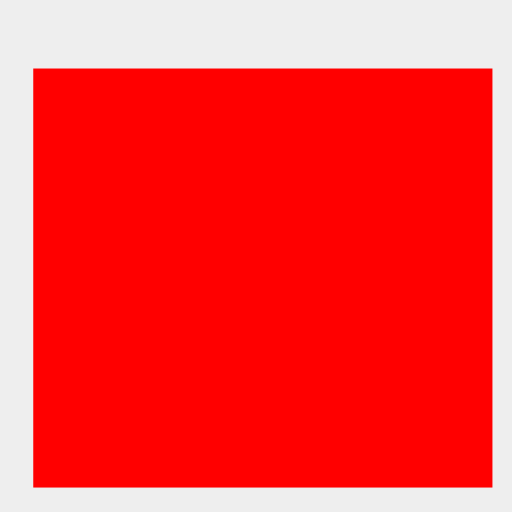


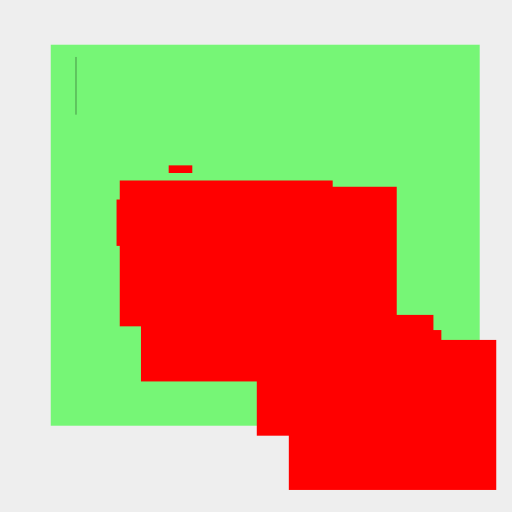
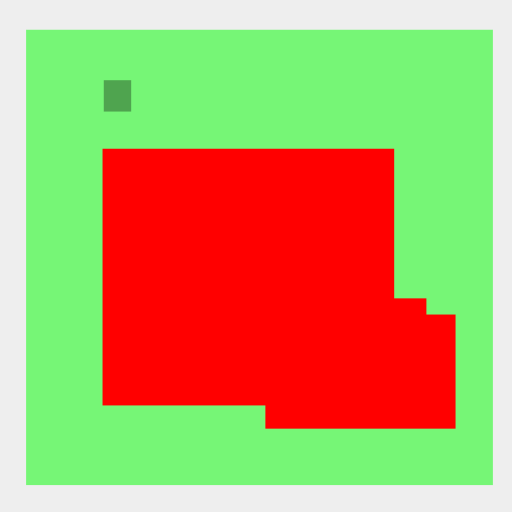
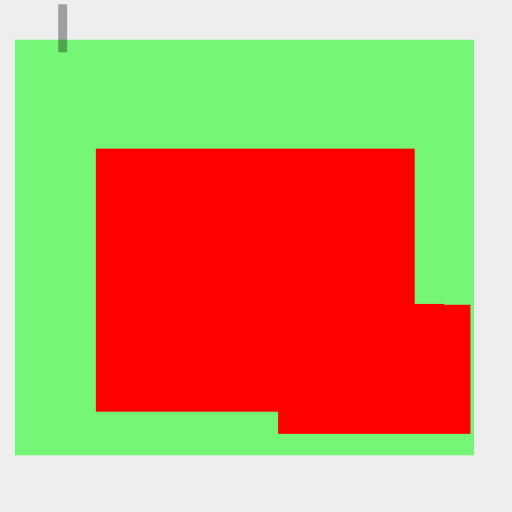
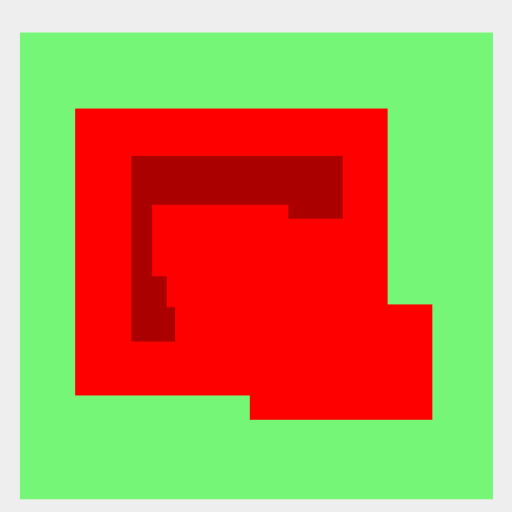
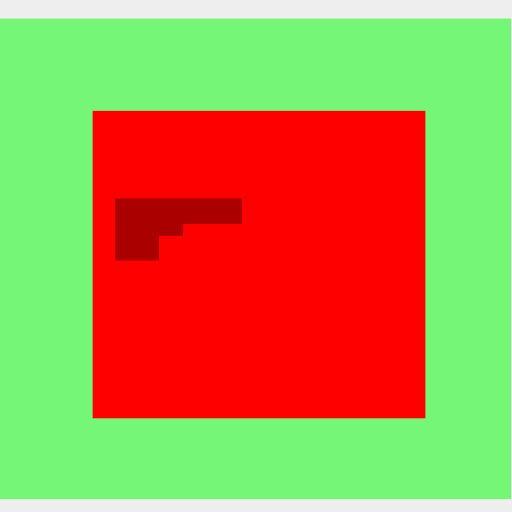
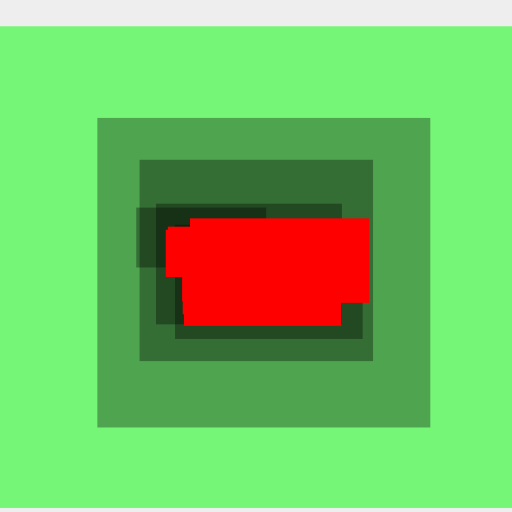
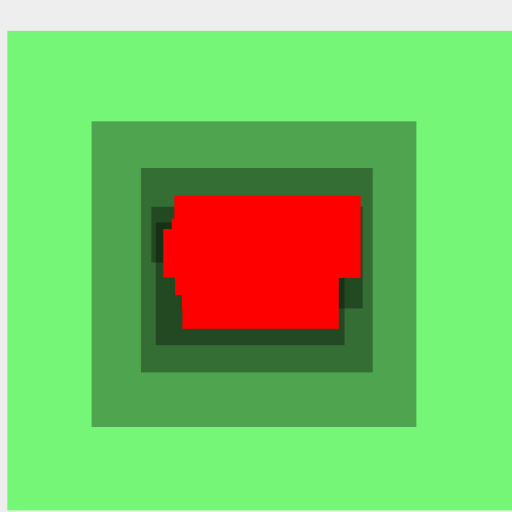
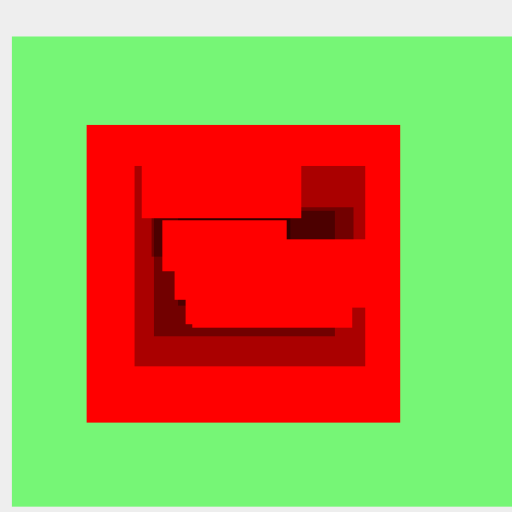
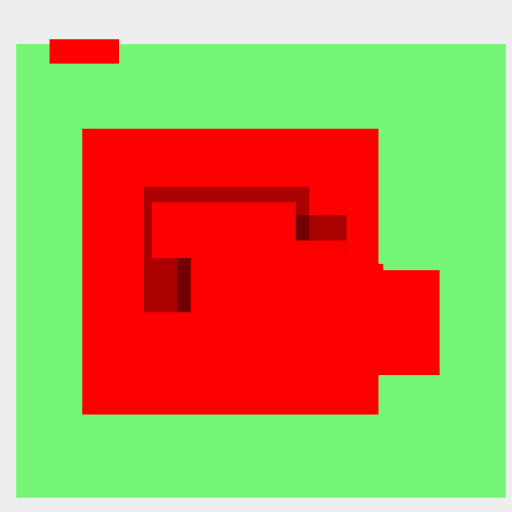
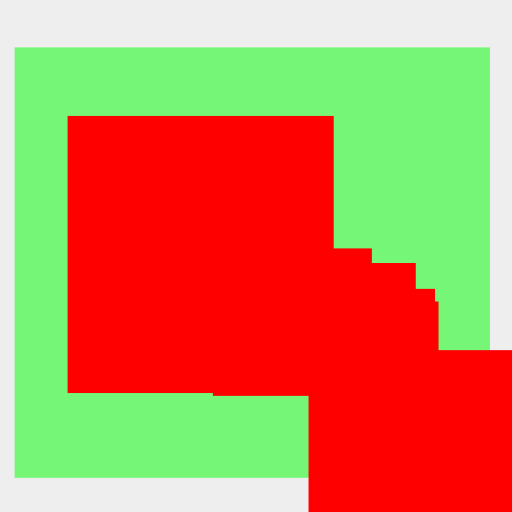


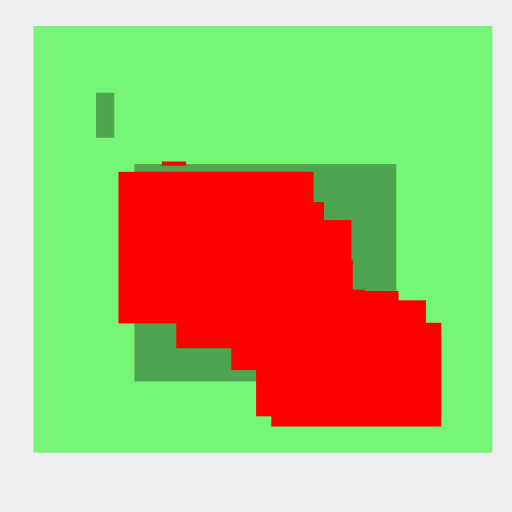
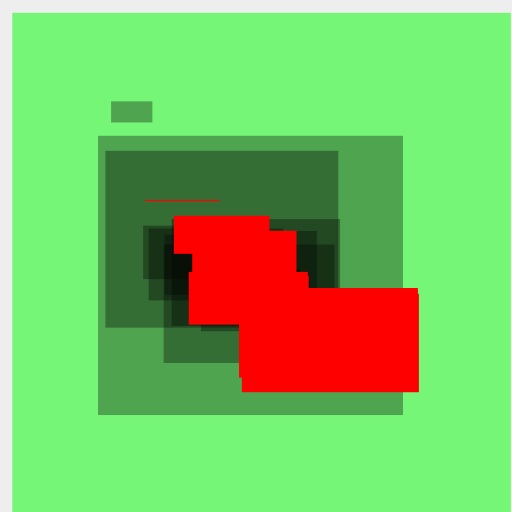
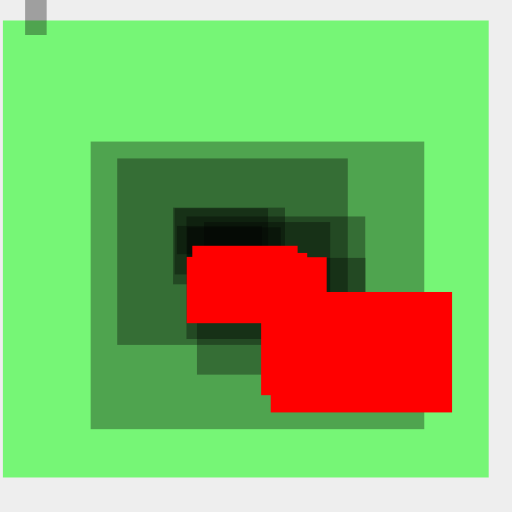
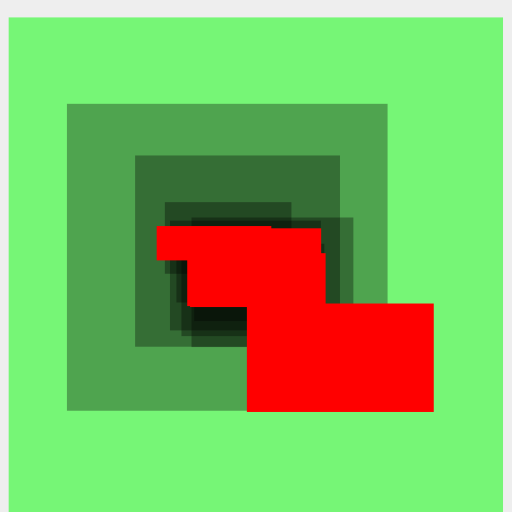
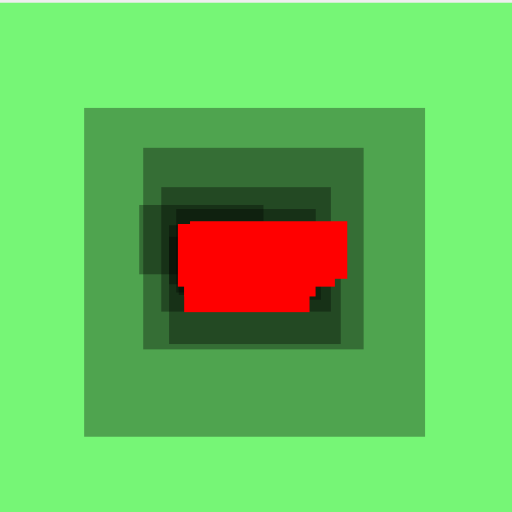
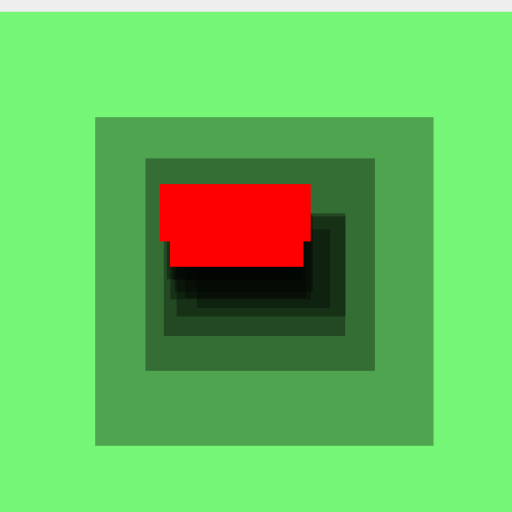
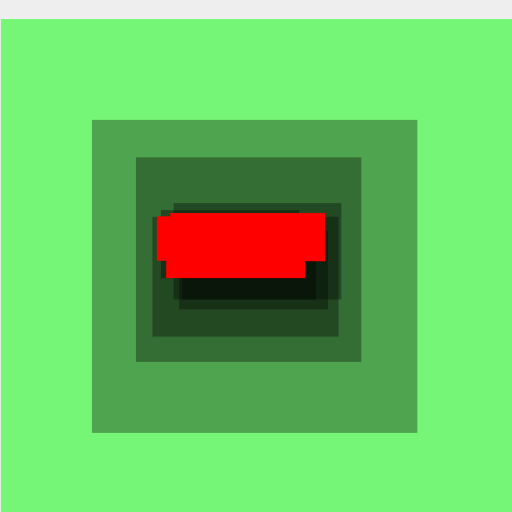
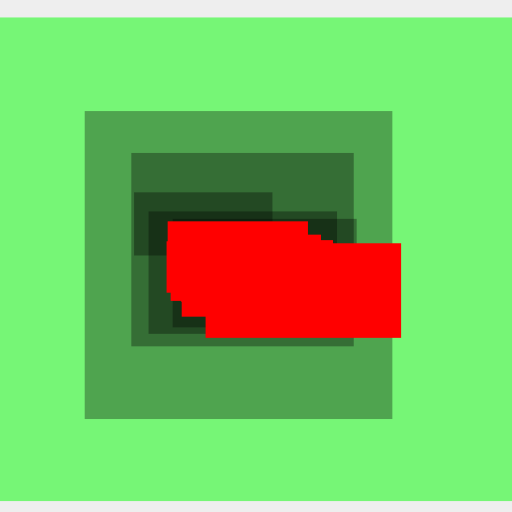
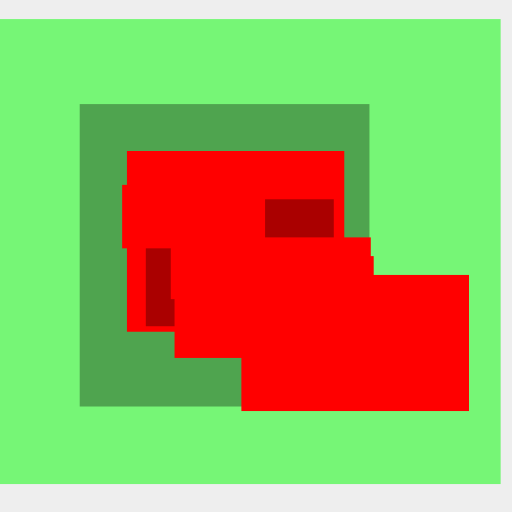
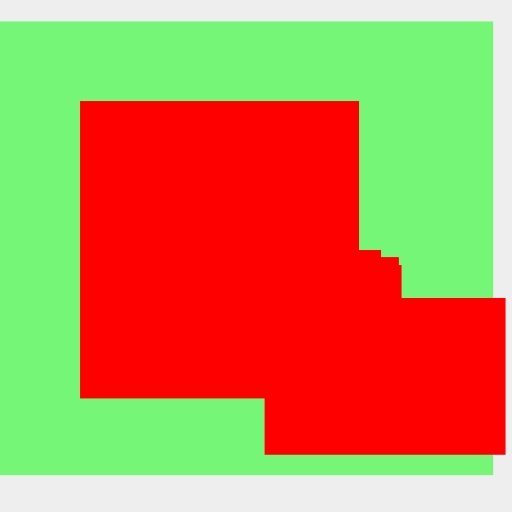


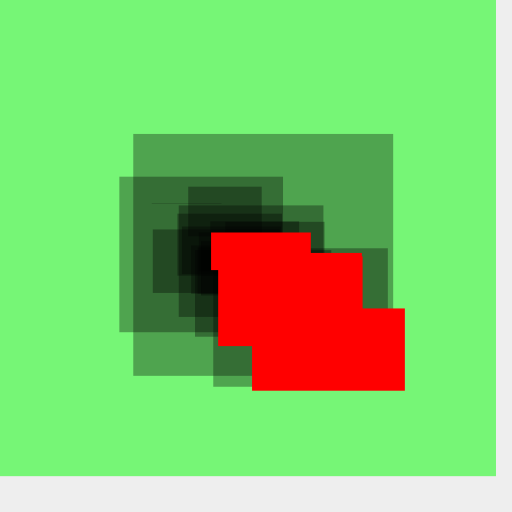
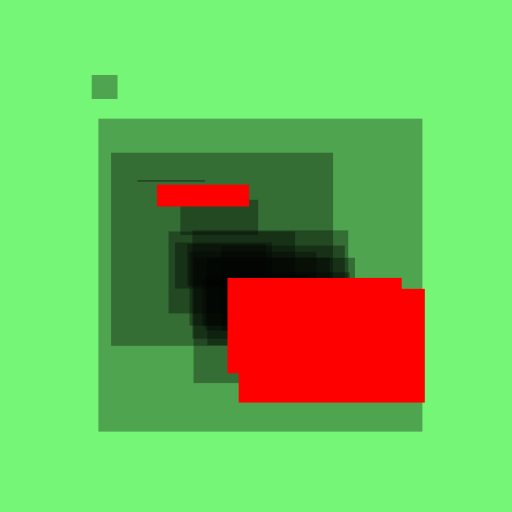
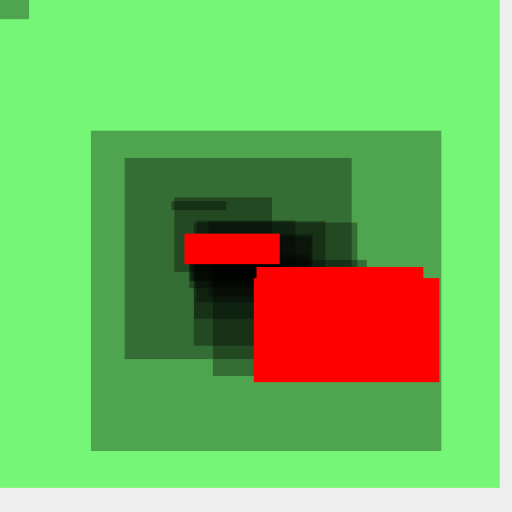
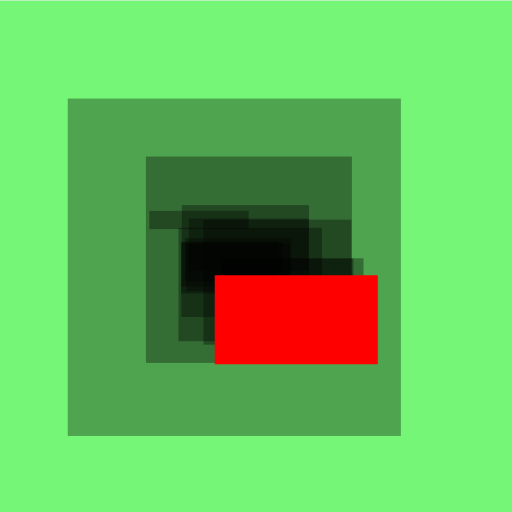
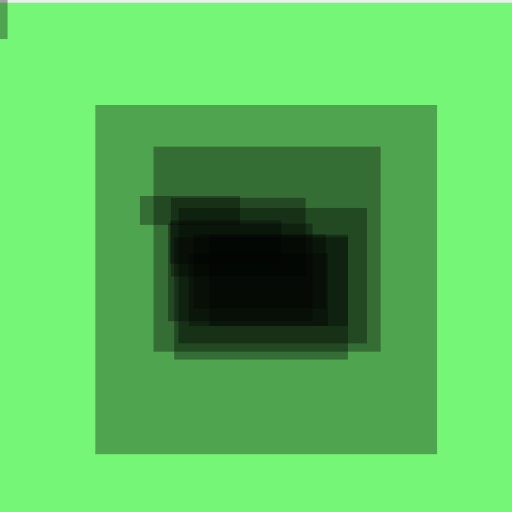
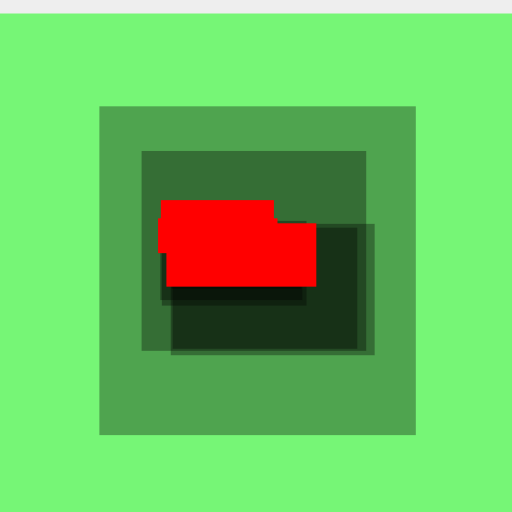
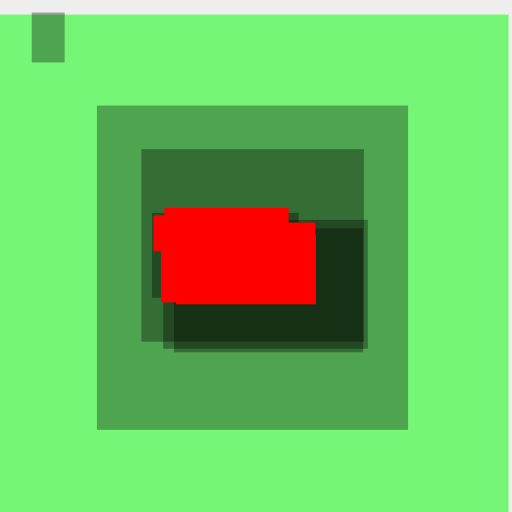
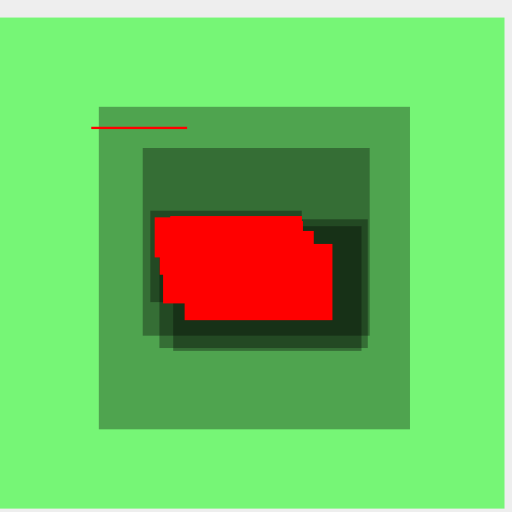
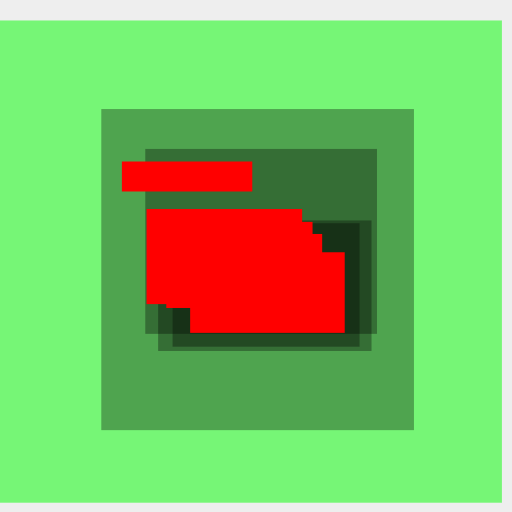
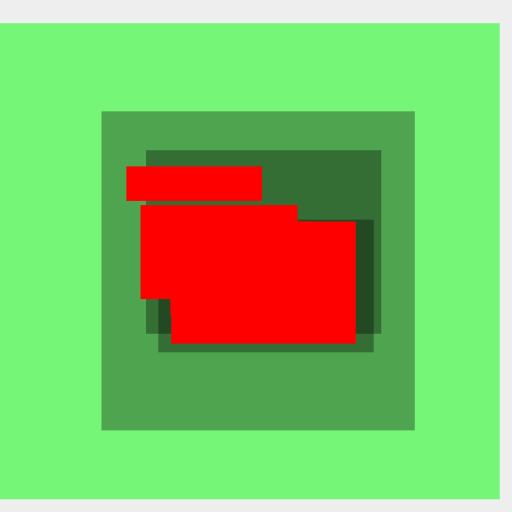


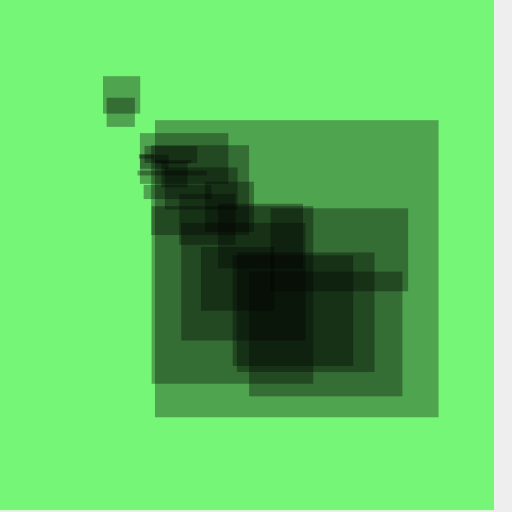
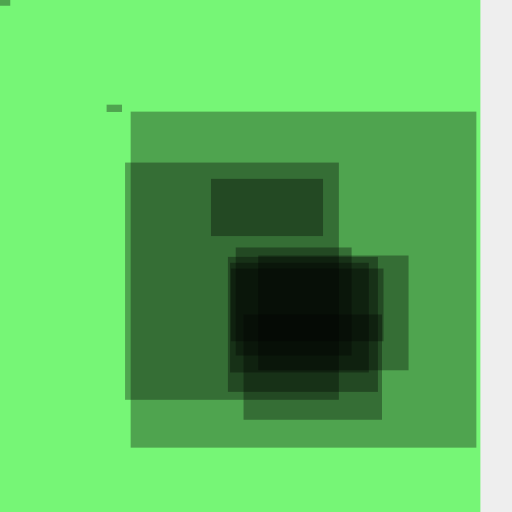
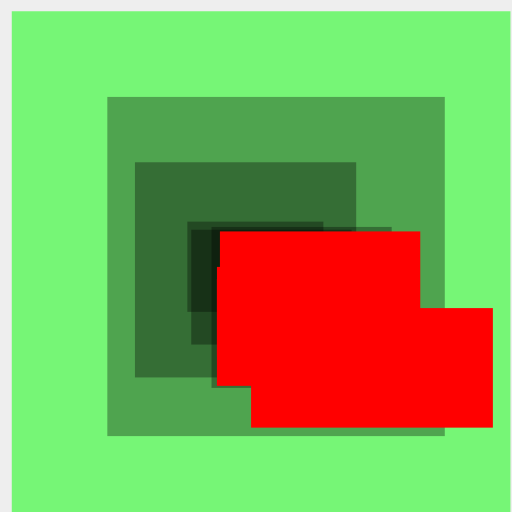
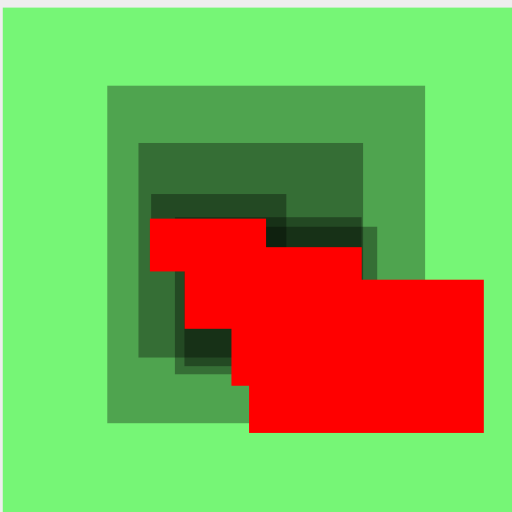
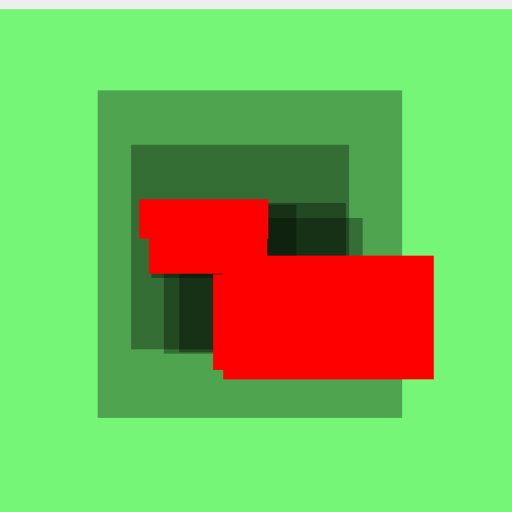
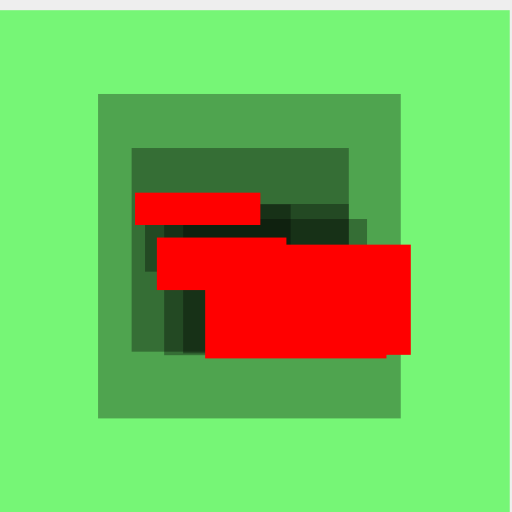
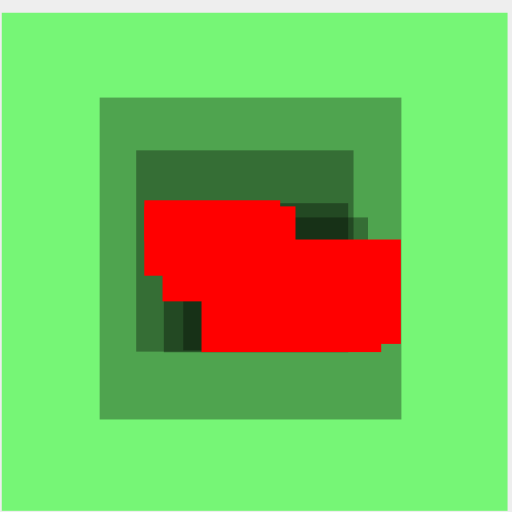
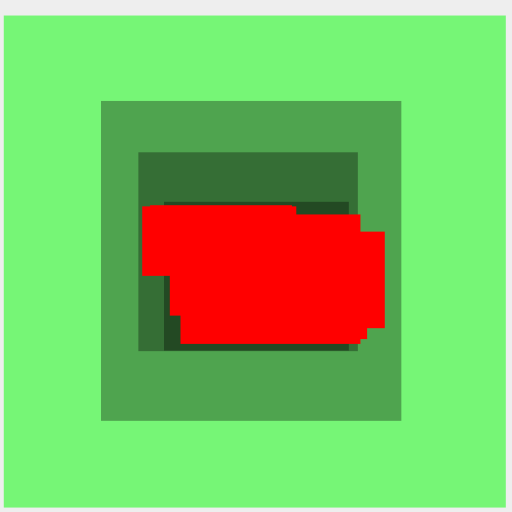
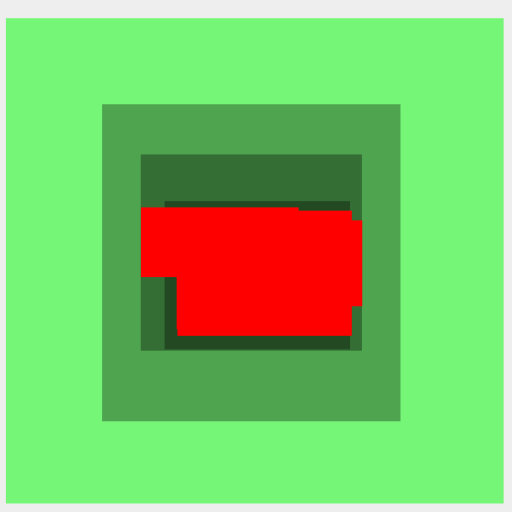
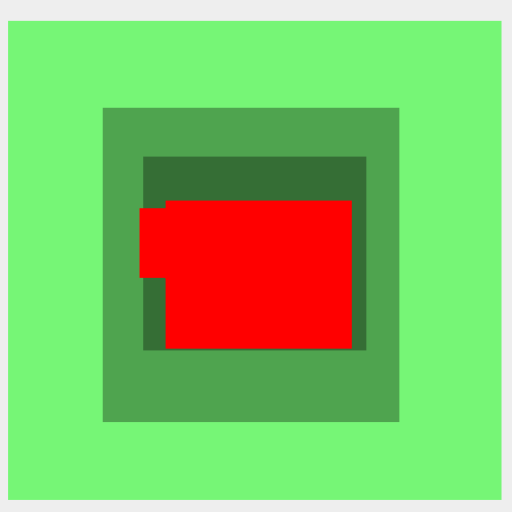


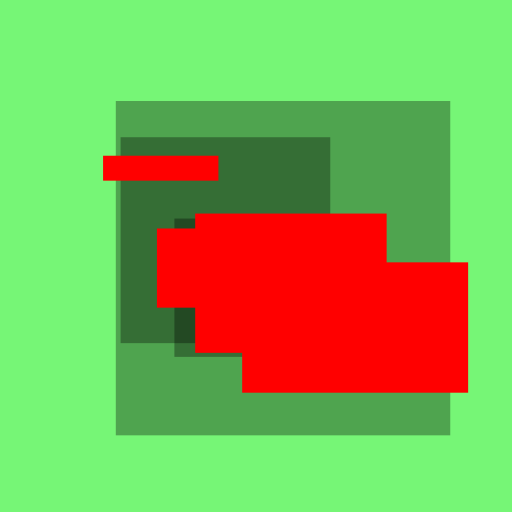
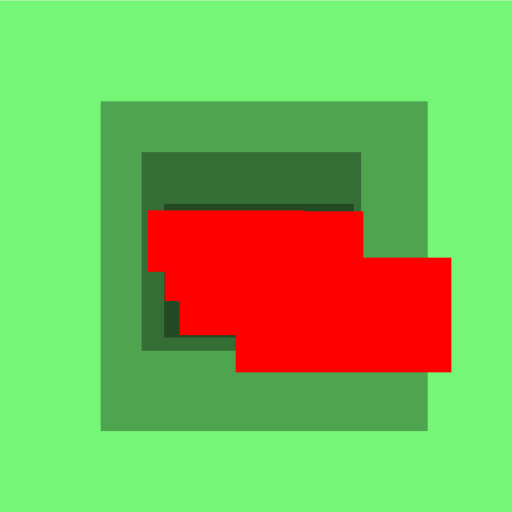
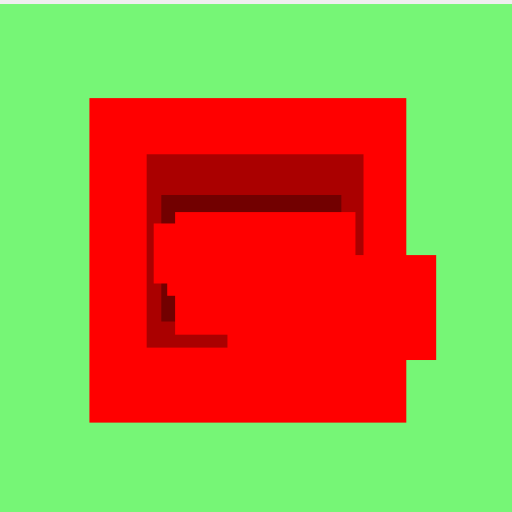
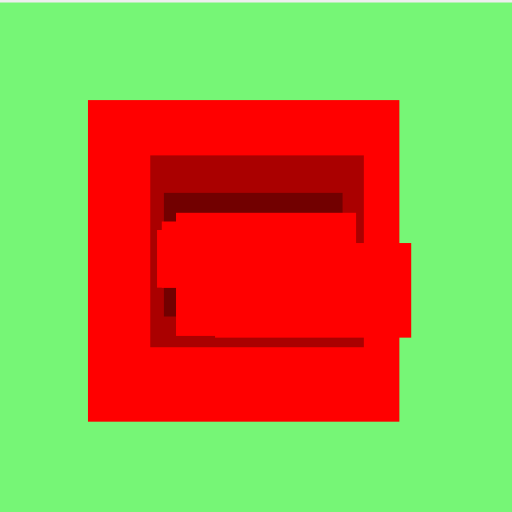
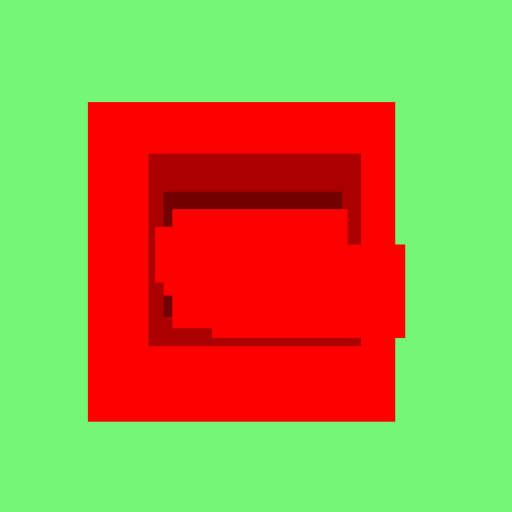
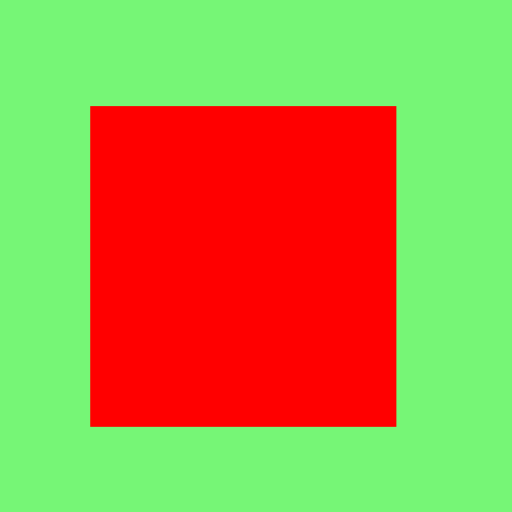
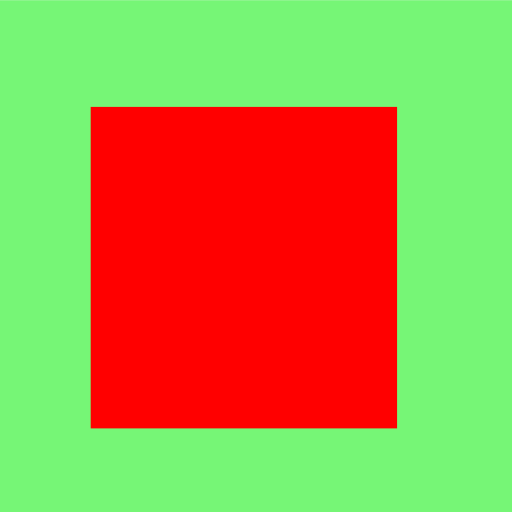
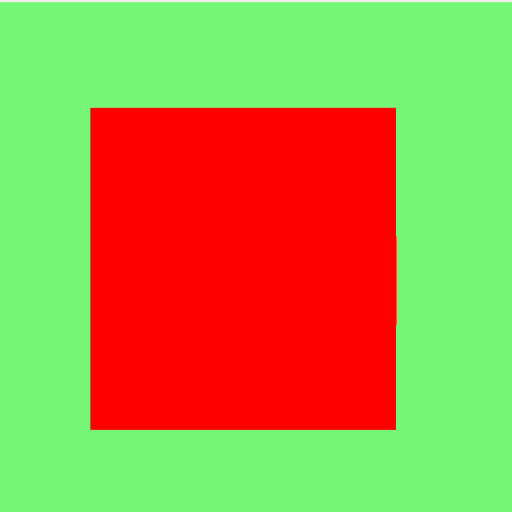
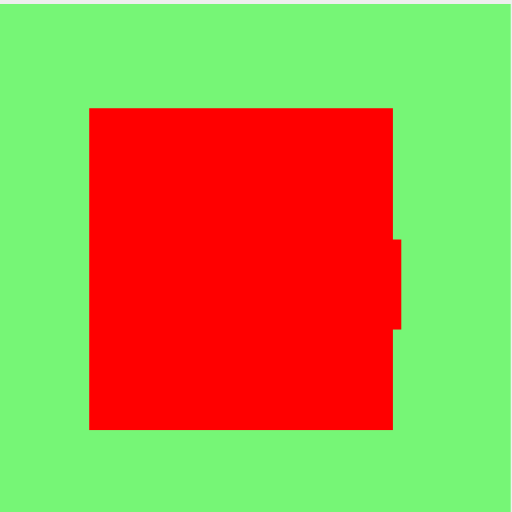
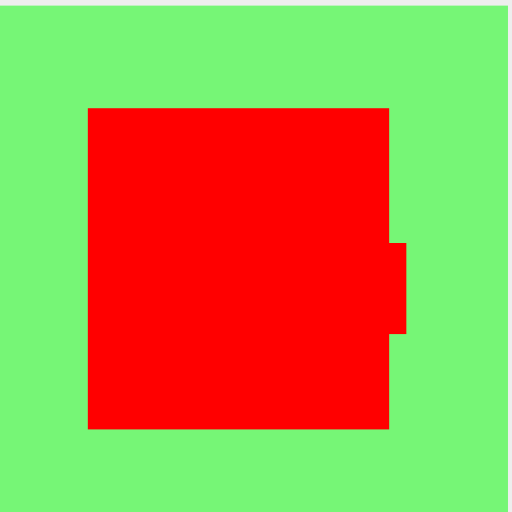


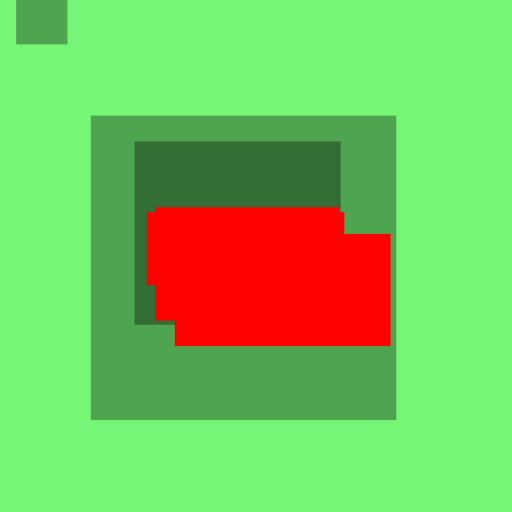
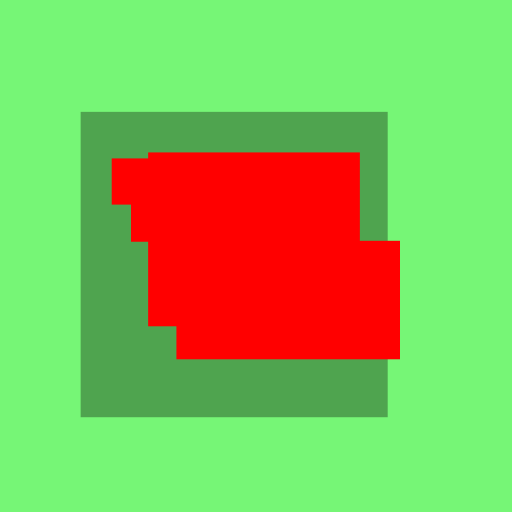
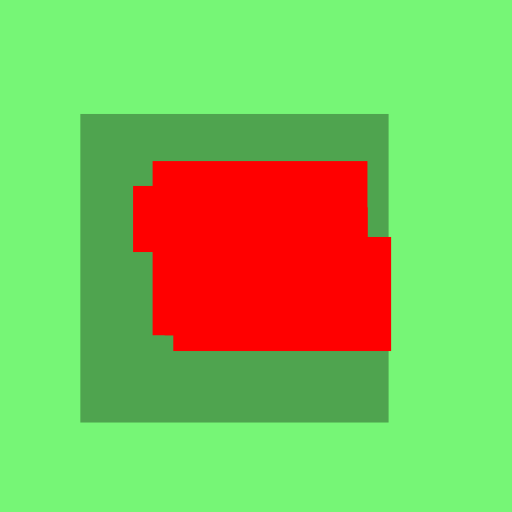
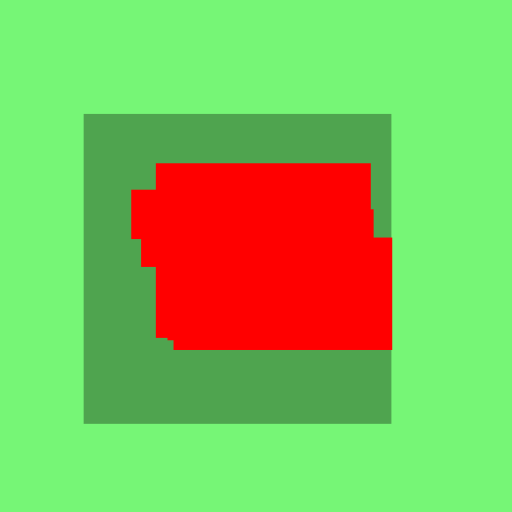
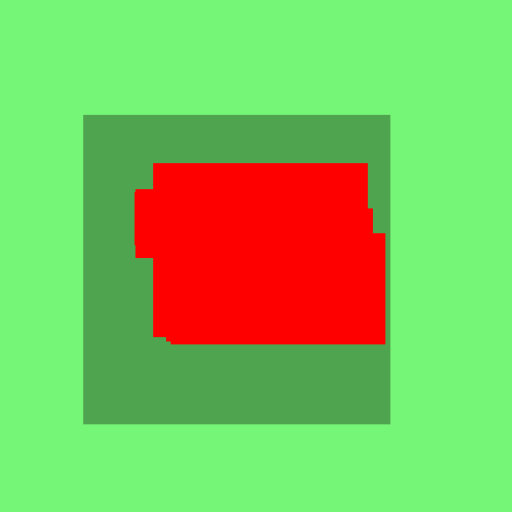
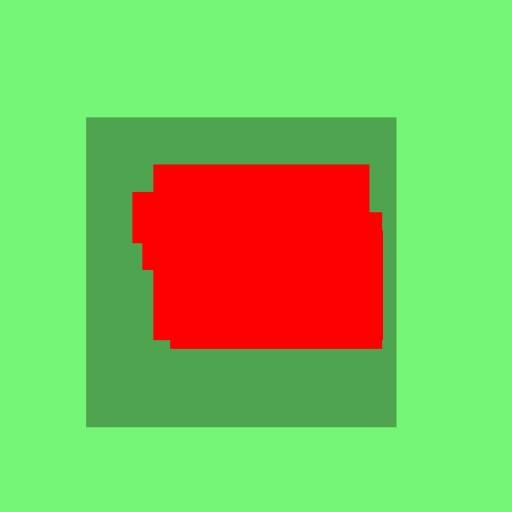
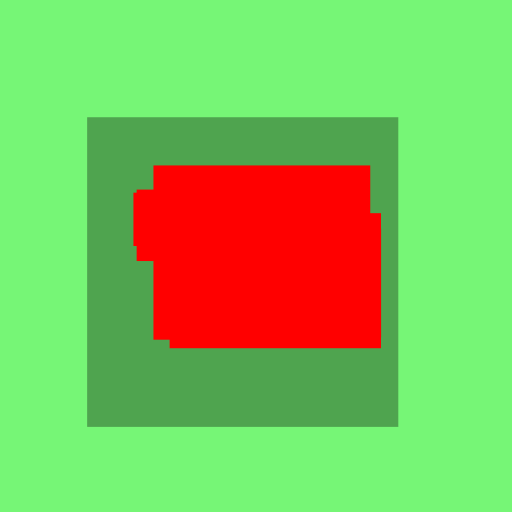
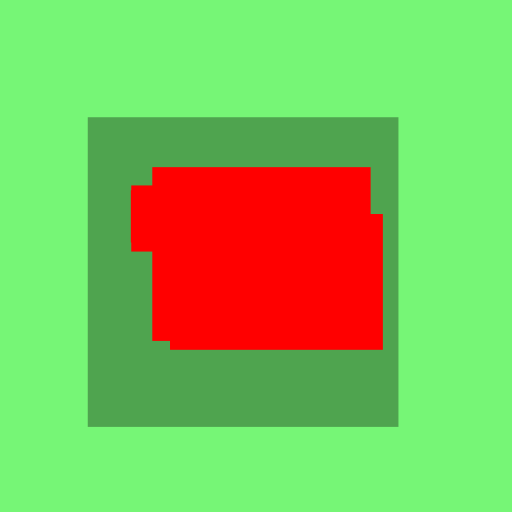
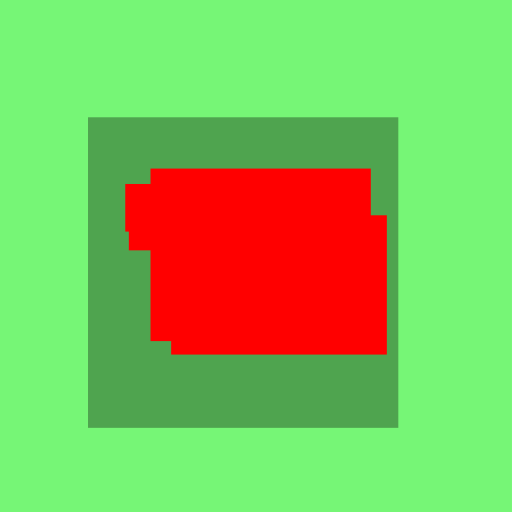
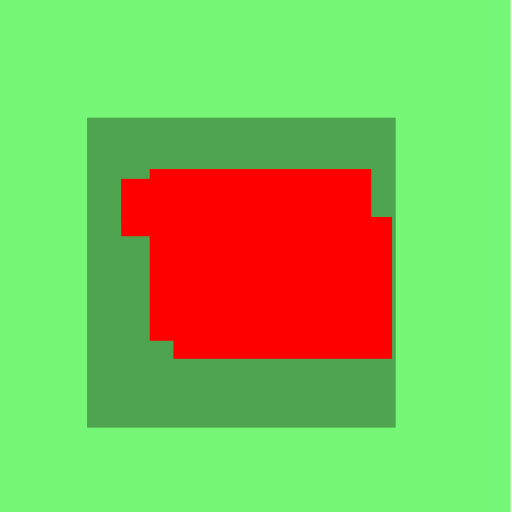


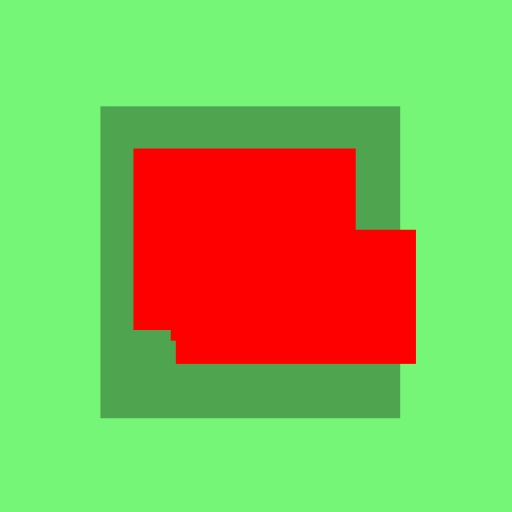
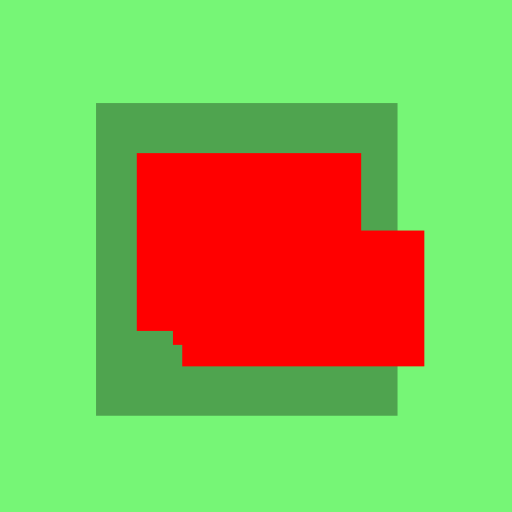
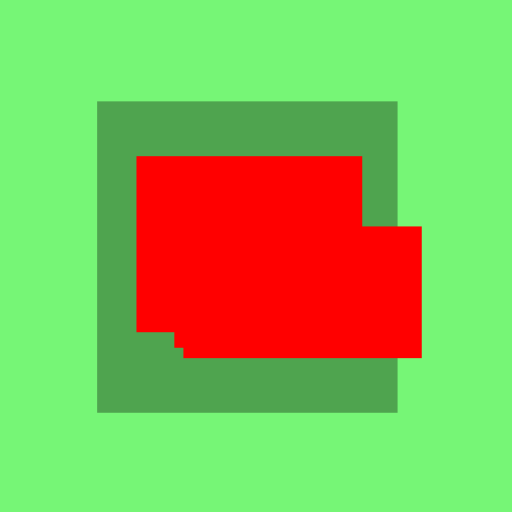
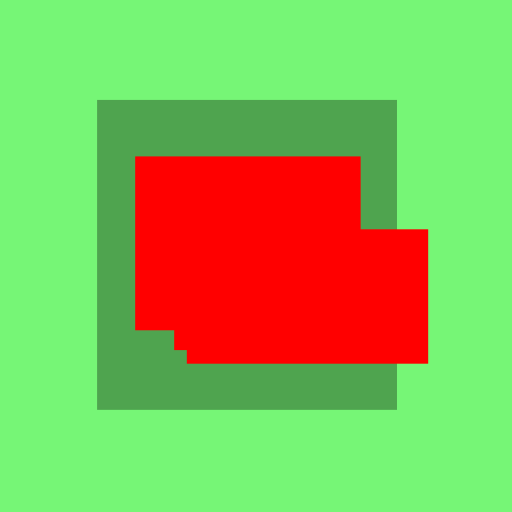
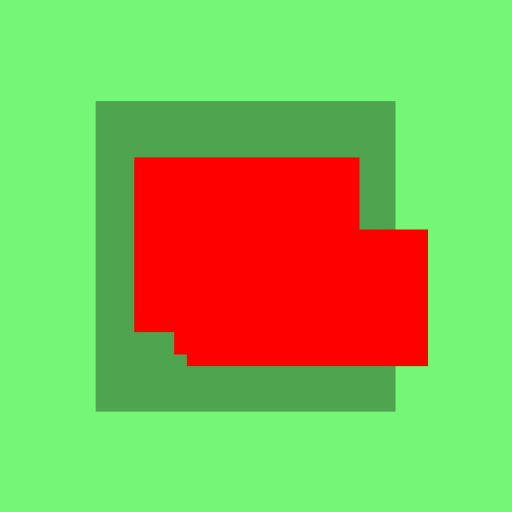
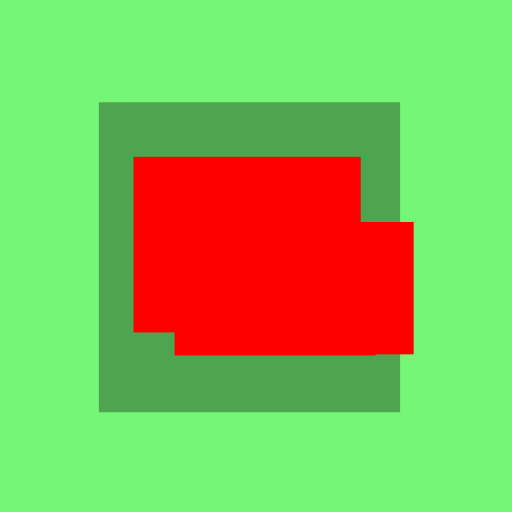
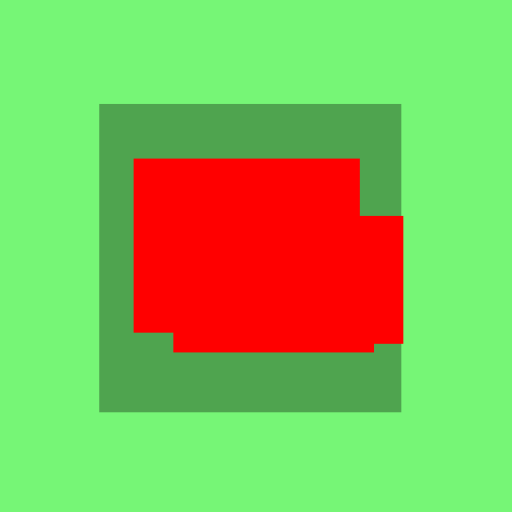
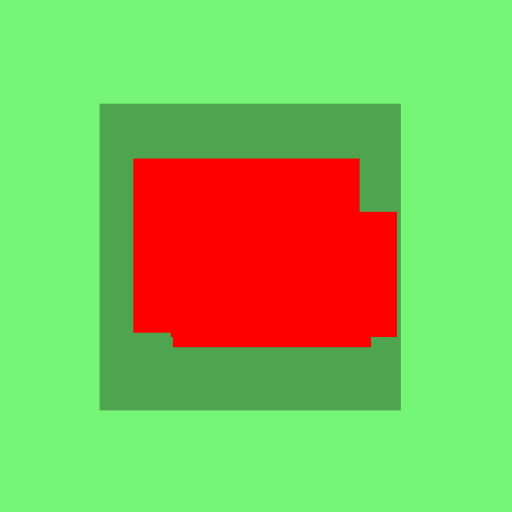
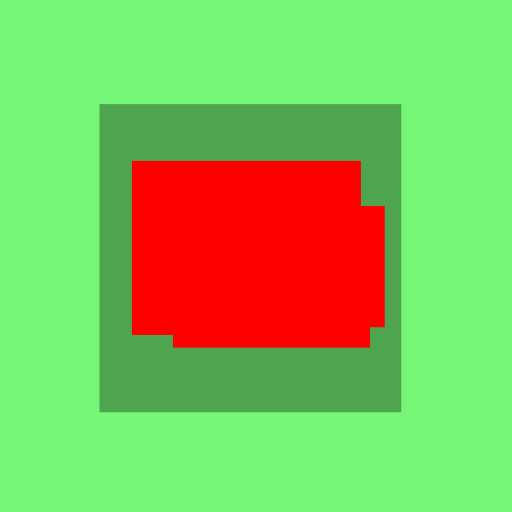
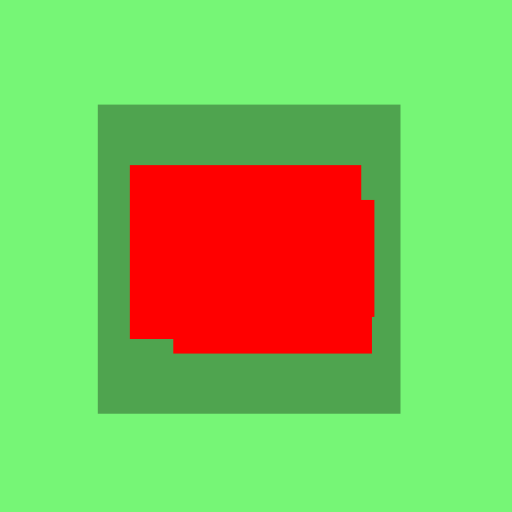


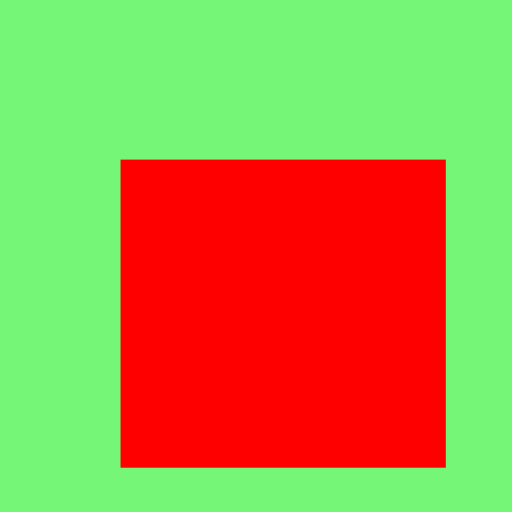
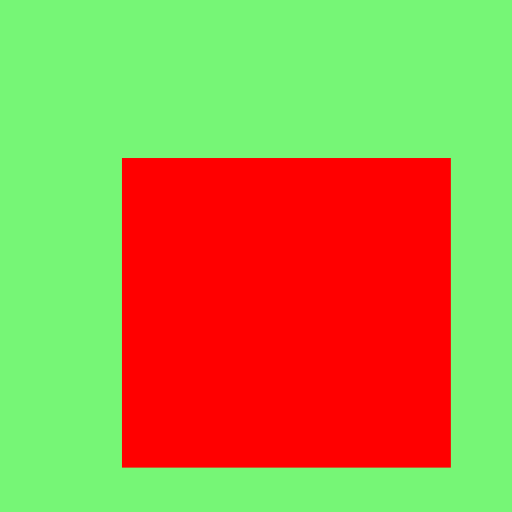
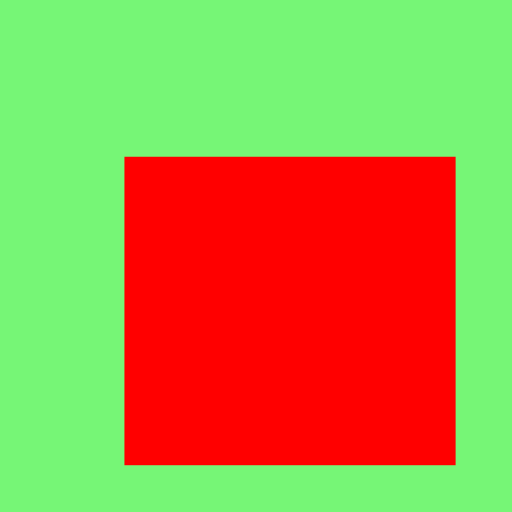
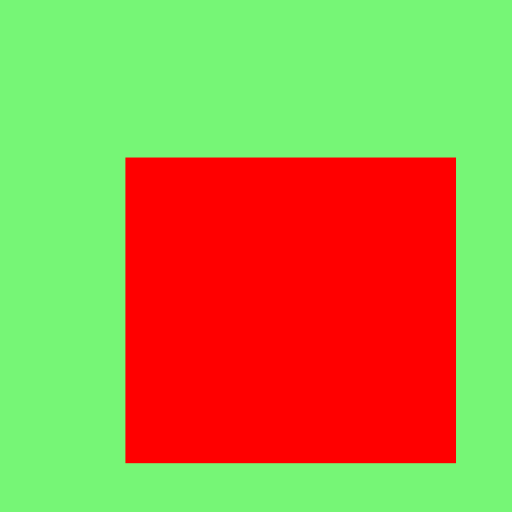
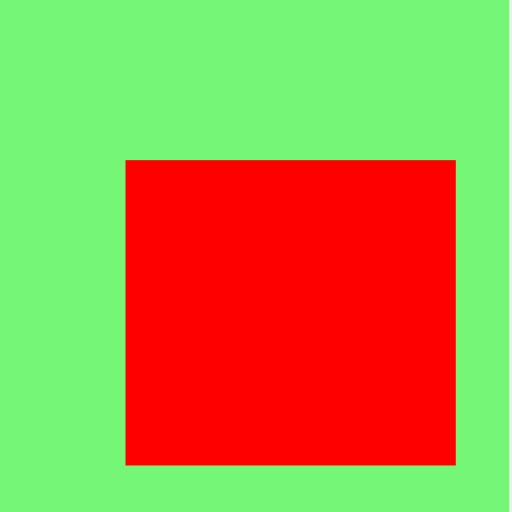
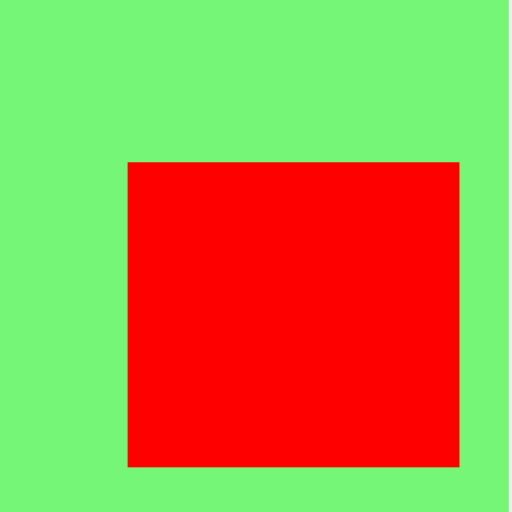
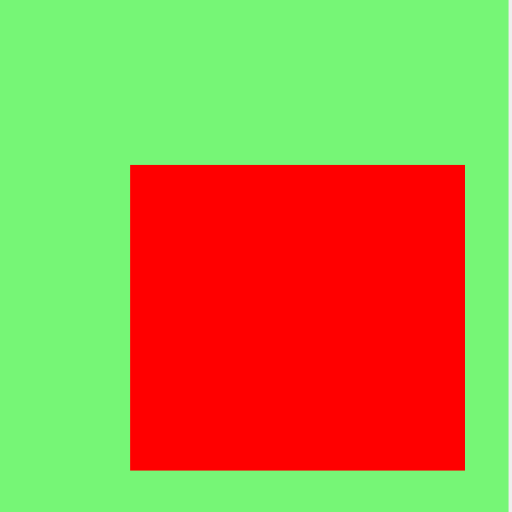
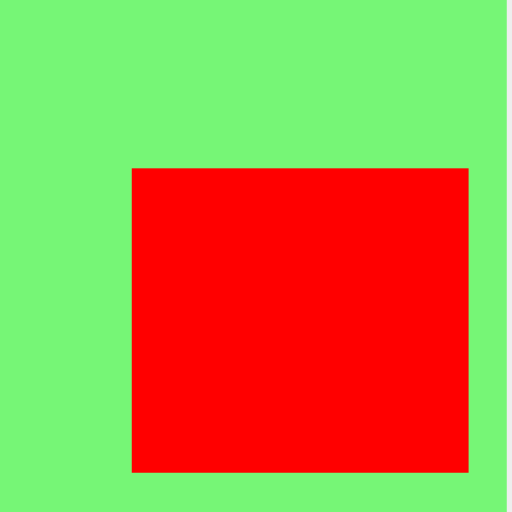
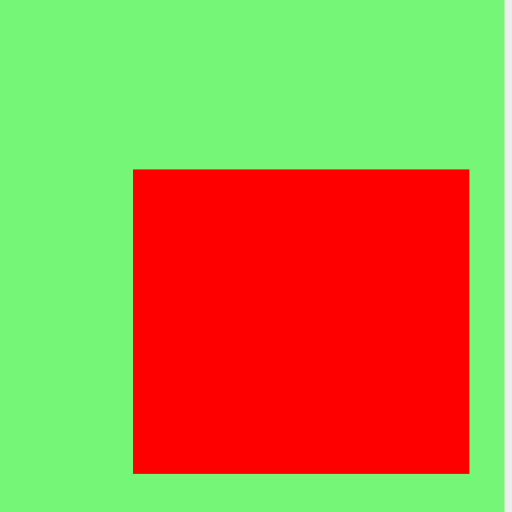
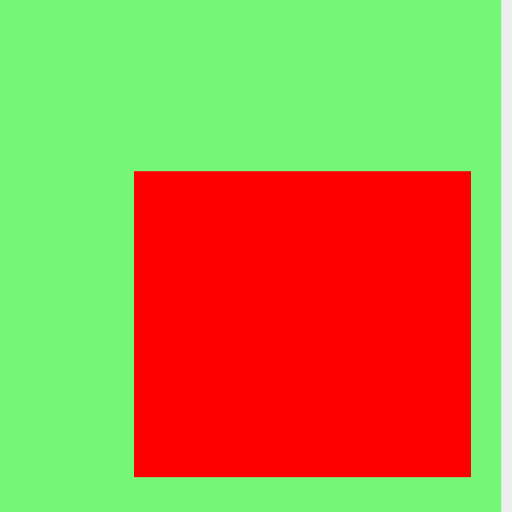


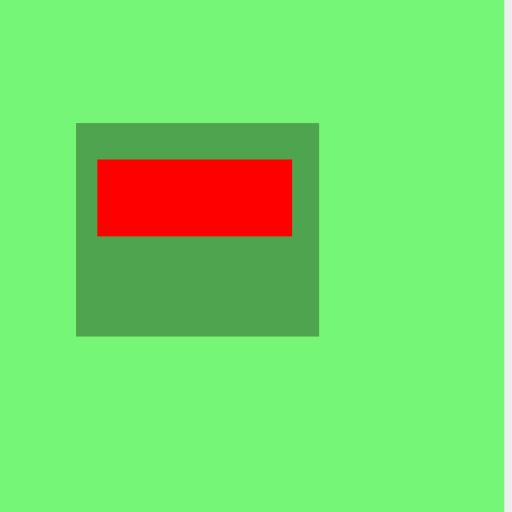
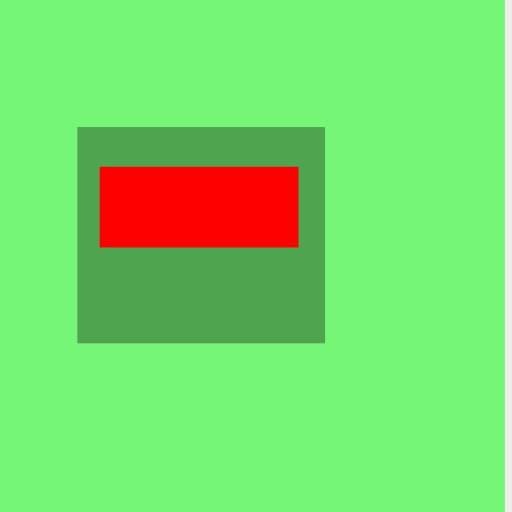
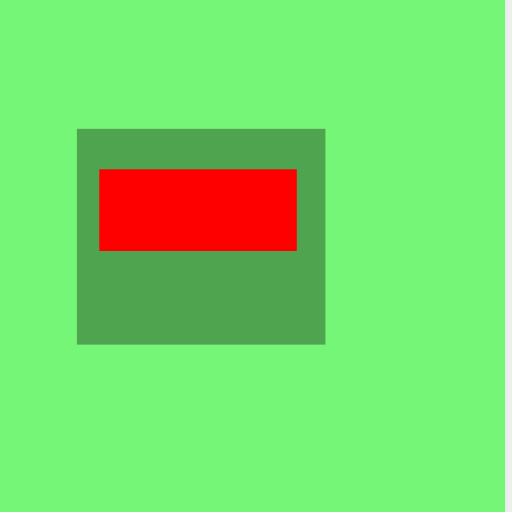
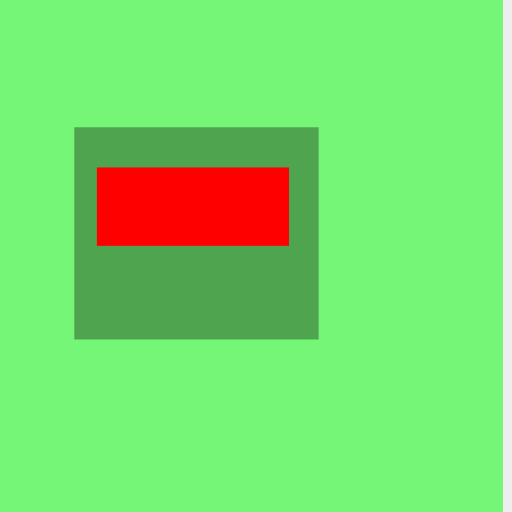
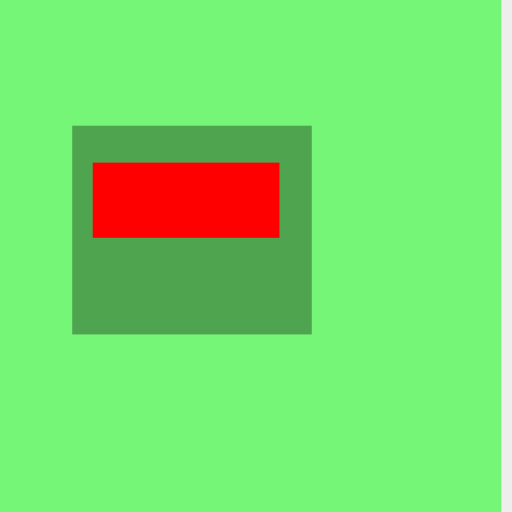
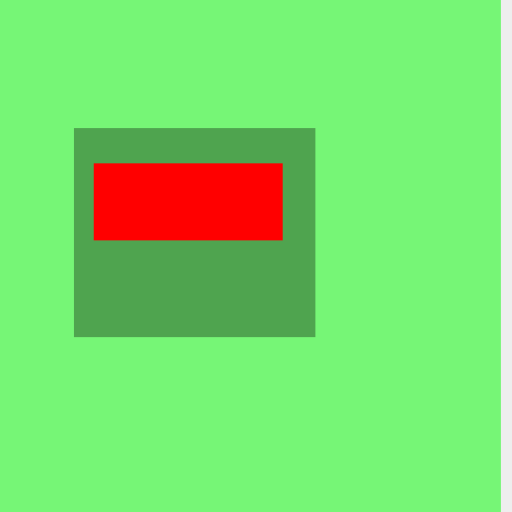
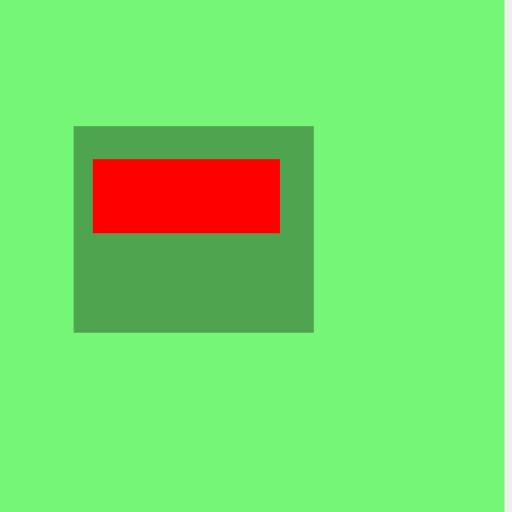
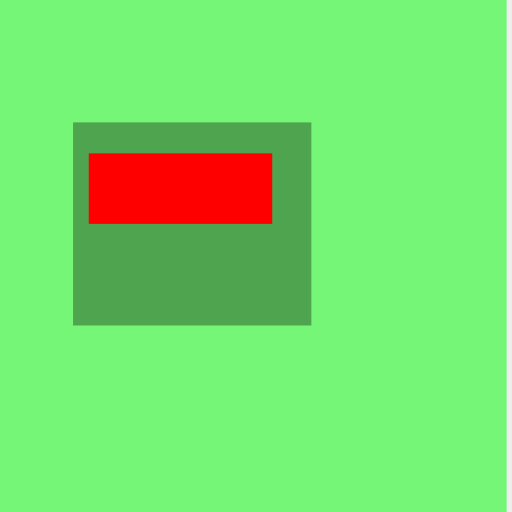
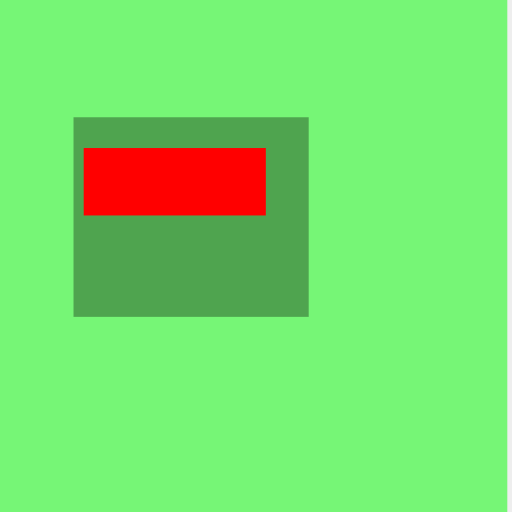
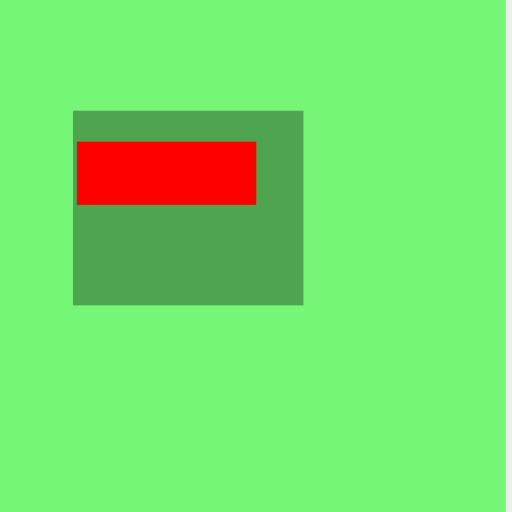

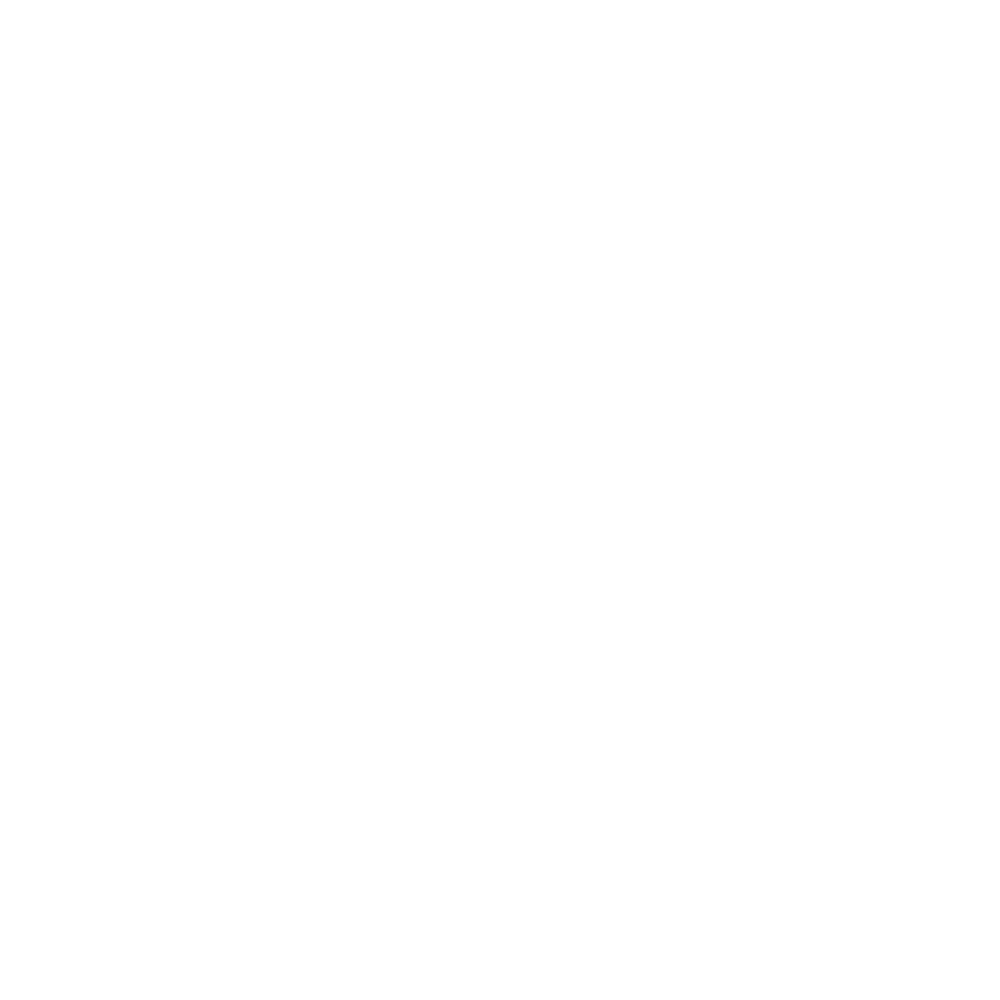

In [33]:
# @title Draw reconstucted layouts
figsize = 10
plt.figure(figsize=(figsize, figsize))

# the original embedding
sc = plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=3)
plt.colorbar(sc).ax.set_zorder(-1) # Set z-order of colorbar to be behind other elements

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="black", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

reconstructions_bytes = [draw_reconstruction(reconstruction) for reconstruction in reconstructions]
reconstructions_base64 = [base64.b64encode(reconstruction_bytes).decode('utf-8') for reconstruction_bytes in reconstructions_bytes]

for data in [reconstructions_base64[i : i + grid_size] for i in range(0, len(reconstructions_base64), grid_size)]:
    preview_layout(data)